## Imports and small functions

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import time
from scipy.stats import pearsonr
import math
import matplotlib.backends.backend_pdf
from scipy.stats import zscore
import pickle

def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues

def distance(x, y):
    if x >= y:
        result = x - y
    else:
        result = y - x
    return result

display(HTML("<style>.container { width:100% !important; }</style>"))
random_colors = cm.rainbow(np.linspace(0,1,8))
cwd = os.getcwd()
somas = {'RGECO_GCamP_Batch2_five':[],'RGECO_GCamP_Batch2_three':['FOV4']}
short_term_strategy = {'both':[], 
                       'T':['GCaMP_POm_Batch3_five_220622_Nrev',
                            'RGECO_GCamP_Batch1_muji_221230_Nrev',
                            'RGECO_GCamP_Batch2_three_221220_Edet',
                            'RGECO_GCamP_Batch2_three_230108_Erev',
                            'RGECO_GCamP_Batch3_muji_230104_Edis_PUPIL',
                            'RGECO_GCamP_Batch3_muji_230104_Nrev_PUPIL',
                            'RGECO_GCamP_Batch3_one_230103_Ndis',
                            'RGECO_GCamP_Batch3_one_230103_Edis',
                            'RGECO_GCamP_Batch3_three_230105_Nrev',
                            'RGECO_GCamP_Batch3_three_230105_Nrev_PUPIL'],
                       'A':['RGECO_GCamP_Batch1_four_220921_Edet',
                            'RGECO_GCamP_Batch2_three_221209_Ndis']
                      }

short_term_strategy = ['GCaMP_POm_Batch3_five_Nrev_220622',
                        'RGECO_GCamP_Batch1_muji_Erev_221230',
                        'RGECO_GCamP_Batch2_three_Edet_221220',
                        'RGECO_GCamP_Batch2_three_Erev_230108',
                        'RGECO_GCamP_Batch3_muji_Edis_230104_PUPIL',
                        'RGECO_GCamP_Batch3_muji_Nrev_230104_PUPIL',
                        'RGECO_GCamP_Batch3_one_Ndis_230103',
                        'RGECO_GCamP_Batch3_one_Edis_230103',
                        'RGECO_GCamP_Batch3_three_Nrev_230105',
                        'RGECO_GCamP_Batch3_three_Nrev_230105_PUPIL',
                        'RGECO_GCamP_Batch1_four_Edet_220921',
                        'RGECO_GCamP_Batch2_three_Ndet_221209']

In [2]:
def calculate_posteriors(group_df, size, protocol, dtype):
    if dtype == 'pupil':
        outcome_label = 'Outcome'
    elif dtype == 'calcium':
        outcome_label = 'Final Outcome'
    else:
        print('invalid dtype')
        
    posteriors = {}
    for block in range(1000):        
        if block+size > group_df.shape[0]:
            break
        else:
            block_df = group_df[block:block+size]
    
            posteriors[block] = {}
            posteriors[block]['reward prob'] = {}
            posteriors[block]['stimulus ratios'] = {}
            posteriors[block]['response rate'] = {}
            posteriors[block]['rare prob'] = {}

            
            if 'det' not in protocol:
                Go_ID = block_df[(block_df[outcome_label].str.contains('hit')) | (block_df[outcome_label].str.contains('miss'))].Stimulus.iloc[0]
                NoGo_ID = float(1) if Go_ID == float(2) else float(2)
                Go = block_df[block_df.Stimulus == Go_ID]
                NoGo = block_df[block_df.Stimulus == NoGo_ID]
            else:
                Go = block_df[block_df.Stimulus != float(3)]
                NoGo = block_df[block_df.Stimulus == float(3)]
                
            rew_probs = {}
            response_probs = {}
            for m, modality in zip(['G','N'],[Go, NoGo]):
                nFA = modality[modality[outcome_label].str.contains('FA')].shape[0]
                nHIT = modality[modality[outcome_label].str.contains('hit')].shape[0]
                ntype = modality.shape[0]
                nrew = modality[modality.Water == float(1)].shape[0]
                rew_prob = nrew/(nFA+nHIT) if nFA+nHIT > 2 else np.nan
                rew_probs[m] = rew_prob
                response_probs[m]  = (nFA+nHIT)/ntype
            rare = Go[(Go.Water == float(0)) & (Go[outcome_label].str.contains('hit'))].shape[0] + NoGo[(NoGo.Water == float(1)) & (NoGo[outcome_label].str.contains('FA'))].shape[0]
            frequent = Go[(Go.Water == float(1)) & (Go[outcome_label].str.contains('hit'))].shape[0] + NoGo[(NoGo.Water == float(0)) & (NoGo[outcome_label].str.contains('FA'))].shape[0]
            if (rare > 2) & (frequent > 2):
                posteriors[block]['rare prob'] = rare/frequent
            else:
                posteriors[block]['rare prob'] = np.nan
            posteriors[block]['reward prob'] = rew_probs
            posteriors[block]['response rate'] = response_probs
            
            ntrials = block_df.shape[0]
            posteriors[block]['stimulus ratios'] = {'G':Go.shape[0]/ntrials,
                                                    'N':NoGo.shape[0]/ntrials}
    
    return posteriors

## Data uploading

In [3]:
ID_colors = {}
cohort_epochs = {}
for dtype in ['events','deltaF','pupil']:
    cohort_dtype = {}
    for root, dirs, files in os.walk(cwd):
        for f in files:
            if (dtype+'_epochs' in f) & ('Old version' not in root):
                ID = root.split('\\')[-1]
                ID_dtype = np.load(root+'\\'+f, allow_pickle=True).item()

                for epoch, epoch_df in ID_dtype.items():
                    if dtype not in cohort_epochs.keys():
                        cohort_epochs[dtype] = {}
                        
                        if epoch not in cohort_epochs[dtype].keys():
                            cohort_epochs[dtype][epoch] = {}
                            cohort_epochs[dtype][epoch][ID] = epoch_df
                        else:
                            cohort_epochs[dtype][epoch][ID] = epoch_df
                    else:
                        if epoch not in cohort_epochs[dtype].keys():
                            cohort_epochs[dtype][epoch] = {}
                            cohort_epochs[dtype][epoch][ID] = epoch_df
                        else:
                            cohort_epochs[dtype][epoch][ID] = epoch_df
                            
for i, (mouse) in enumerate(cohort_epochs['deltaF']['all'].keys()):
    ID_colors[mouse] = random_colors[i]

In [4]:
cohort_deltaF = {}
cohort_correlations = {}
cohort_pupil = {}
cohort_events = {}
cohort_params = {}
for root, dirs, files in os.walk(cwd):
    for f in files:
        if ('processed_calcium.npy' in f) & ('Old version' not in root):
            ID = root.split('\\')[-1]
            ID_calcium = np.load(root+'\\'+f, allow_pickle=True).item()
            ID_deltaF = ID_calcium['deltaF']
            ID_correlations = ID_calcium['correlations']
            ID_events = ID_calcium['events']
            cohort_deltaF[ID] = ID_deltaF
            cohort_correlations[ID] = ID_correlations
            cohort_events[ID] = ID_events
        if ('processed_pupil.csv' in f) & ('Old version' not in root):
            ID = root.split('\\')[-1]
            ID_pupil = pd.read_csv(root+'\\'+f, index_col=list(range(17)))
            cohort_pupil[ID] = ID_pupil
        if ('params.npy' in f) & ('Old version' not in root):
            ID = root.split('\\')[-1]
            ID_params = np.load(root+'\\'+f, allow_pickle=True).item()
            cohort_params[ID] = ID_params

In [5]:
def redefine_outcomes(deltaF):
    final_outcomes = []
    for index, rows in deltaF.iterrows():
        rew = index[12]
        outcome = index[16]
        ttype = index[15]

        if ttype == float(1):
            if rew == float(1):
                final = 'Tactile rewarded '+outcome
            else:
                final = 'Tactile unrewarded '+outcome
        elif ttype == float(2):
            if rew == float(1):
                final = 'Auditory rewarded '+outcome
            else:
                final = 'Auditory unrewarded '+outcome        
        else:
            if rew == float(1):
                final = 'Catch rewarded '+outcome
            else:
                final = 'Catch unrewarded '+outcome           
        final_outcomes.append(final)
    
    deltaF.index = pd.MultiIndex.from_tuples([tuple(list(x) + [final_outcomes[i]]) for i, (x) in enumerate(deltaF.index)], names=deltaF.index.names+['Final Outcome'])           
    
    return deltaF

In [6]:
all_pupil = pd.concat(cohort_pupil)
pupil_behavior = []
for mouse in all_pupil.index.get_level_values(0).unique():
    mouse_df = all_pupil[all_pupil.index.get_level_values(0) == mouse]
    for session in mouse_df.index.get_level_values('Unique session').unique():
        session_df = mouse_df[mouse_df.index.get_level_values('Unique session') == session]
        protocol = session_df.index.get_level_values('Protocol')[0]
        first_channel = session_df.index.get_level_values('Channel').unique()[0]
        first_channel_df = session_df[session_df.index.get_level_values('Channel') == first_channel]
        first_channel_df = first_channel_df.reset_index().iloc[:,:18]
        first_channel_df = first_channel_df.rename({'level_0':'ID'}, axis=1)
        first_channel_df['Anticipatory licks'] = [x+1 for x in list(first_channel_df['Anticipatory licks'])]
        first_channel_df['Response latency'] = [(float(x)/1000)-3 for x in list(first_channel_df['Response latency'].replace({'-':np.nan}))]
        posteriors_df = pd.DataFrame(calculate_posteriors(first_channel_df, first_channel_df.shape[0], protocol, 'pupil')[0])
        hit_rate = posteriors_df['response rate']['G']
        FA_rate = posteriors_df['response rate']['N']
        correct = first_channel_df[(first_channel_df.Outcome  == 'hit') | (first_channel_df.Outcome  == 'CR')].shape[0]
        CP_rate = correct/first_channel_df.shape[0]
        FA_latency = (first_channel_df[first_channel_df.Outcome == 'FA']['Response latency']).mean()
        hit_latency = (first_channel_df[first_channel_df.Outcome == 'hit']['Response latency']).mean()
#         FA_licks = (first_ROI_df[first_ROI_df.Outcome == 'FA']['Anticipatory licks']).mean()
#         hit_licks = (first_ROI_df[first_ROI_df.Outcome == 'hit']['Anticipatory licks']).mean()
#         norm_licks = FA_licks/hit_licks
#         FA_licks_rew = (first_ROI_df[(first_ROI_df.Outcome == 'FA') & (first_ROI_df.Water == float(1))]['Reward licks']).mean()
#         hit_licks_rew = (first_ROI_df[(first_ROI_df.Outcome == 'hit') & (first_ROI_df.Water == float(1))]['Reward licks']).mean()
#         final_df = pd.DataFrame([CP_rate, hit_rate, FA_rate, prop_rare, norm_licks, FA_licks, hit_licks, FA_licks_rew, hit_licks_rew, hit_latency, FA_latency, protocol], 
#                                 index=['CP rate','Hit rate','FA rate','Rare outcome proportion','Hit/FA licks', 'Hit ant', 'FA ant', 'Hit rew','FA rew', 'Hit latency','FA latency', 'Protocol'], 
#                                 columns=[mouse+'_'+session]).T
#         final_df = final_df.reset_index().set_index(['index','Protocol'])
#         imaging_behavior.append(final_df)
# imaging_behavior = pd.concat(imaging_behavior)
# imaging_behavior.index = imaging_behavior.index.set_names('FOV',level=0)

ZeroDivisionError: division by zero

In [7]:
all_deltaF = pd.concat(cohort_deltaF)
deltaF = redefine_outcomes(all_deltaF)
expectation = []
for index, rows in deltaF.iterrows():
    t = index[20]
    if t in ['Tactile rewarded hit', 'Auditory rewarded hit', 'Tactile unrewarded FA', 'Auditory unrewarded FA']:
        expectation.append('expected')
    elif t in ['Tactile rewarded FA', 'Auditory rewarded FA', 'Tactile unrewarded hit', 'Auditory unrewarded hit']:
        expectation.append('unexpected')
    else:
        expectation.append('no expectation')
deltaF['expectation'] = expectation
values = [x+(y,) for x,y in zip(deltaF.index.values, deltaF['expectation'])]
names = list(deltaF.index.names)
names.append('expectation')
deltaF.index = pd.MultiIndex.from_tuples(values, names=names)
deltaF = deltaF.iloc[:,:-1]
deltaF

0    \
                         Unique session     Protocol Date   FOV    Channel Trial ROI Response latency Prestim licks Anticipatory licks Reward licks Water Water_time Timeout_end Stimulus Outcome Trial type Unique_trial          Unique_ROI                  Final Outcome           expectation                
GCaMP_POm_Batch3_five    Edet_220602_FOV1   Edet     220602 FOV1   Green   1     1   3615             0.0           1.0                1.0          1.0   4650       -           1.0      hit     G          Edet_220602_FOV1_1    Edet_220602_FOV1_Green_1    Tactile rewarded hit    expected        4.496609   
                                                                           2     1   3242             1.0           1.0                1.0          0.0   4253       10054       2.0      hit     G          Edet_220602_FOV1_2    Edet_220602_FOV1_Green_1    Auditory unrewarded hit unexpected      1.012310   
                                                                           3     1   3470             0.0           1.0                1.0          1.0   4503       -           1.0      hit     G          Edet_220602_FOV1_3    Edet_220602_FOV1_Green_1    Tactile rewarded hit    expected       -0.079006   
                                                                           4     1   3425             0.0           1.0                1.0          1.0   4461       -           1.0      hit     G          Edet_220602_FOV1_4    Edet_220602_FOV1_Green_1    Tactile rewarded hit    expected        2.265806   
                                                                           5     1   3246             8.0           1.0                1.0          0.0   4250       -           3.0      FA      N          Edet_220602_FOV1_5    Edet_220602_FOV1_Green_1    Catch unrewarded FA     no expectation  0.101258   
...                                                                                                                                                                                                                                                                                                         ...   
RGECO_GCamP_Batch3_three Erev_230105_FOV2.1 Erev     230105 FOV2.1 Green   56    77  3209             3.0           2.0                0.0          0.0   4218       10018       2.0      FA      A          Erev_230105_FOV2.1_56 Erev_230105_FOV2.1_Green_77 Auditory unrewarded FA  expected        0.103665   
                                                                           57    77  -                0.0           0.0                0.0          0.0   -          -           1.0      miss    T          Erev_230105_FOV2.1_57 Erev_230105_FOV2.1_Green_77 Tactile unrewarded miss no expectation -0.077047   
                                                                           58    77  -                0.0           0.0                0.0          0.0   -          -           2.0      CR      A          Erev_230105_FOV2.1_58 Erev_230105_FOV2.1_Green_77 Auditory unrewarded CR  no expectation -0.056545   
                                                                           59    77  -                0.0           0.0                0.0          0.0   -          -           3.0      CR      N          Erev_230105_FOV2.1_59 Erev_230105_FOV2.1_Green_77 Catch unrewarded CR     no expectation -0.118481   
                                                                           60    77  -                0.0           0.0                0.0          0.0   -          -           1.0      miss    T          Erev_230105_FOV2.1_60 Erev_230105_FOV2.1_Green_77 Tactile unrewarded miss no expectation  0.002959   

                                                                                                                                                                                                                                                                                                            1    \
 

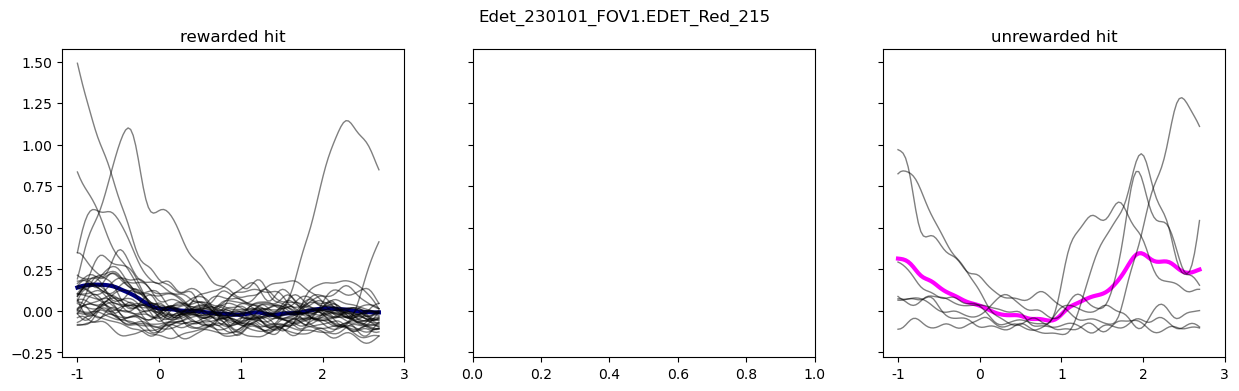

In [8]:
extinction_df = deltaF[deltaF.index.get_level_values('Protocol') == 'Edet']
for channel in ['Red']:
    channel_df = extinction_df[extinction_df.index.get_level_values('Channel') == channel]
    ROI_groups = channel_df.groupby(channel_df.index.get_level_values('Unique_ROI'))
    for roi in channel_df.index.get_level_values('Unique_ROI').unique():
        if roi == 'Edet_230101_FOV1.EDET_Red_215':
            ROI_df= ROI_groups.get_group(roi)
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4), sharey=True)      
            for col, (ttype, color) in enumerate(zip(['rewarded hit','rewarded FA','unrewarded hit'],['navy','cyan','magenta'])):
                ttype_df = ROI_df[(ROI_df.index.get_level_values('Final Outcome') == 'Tactile '+ttype) | (ROI_df.index.get_level_values('Final Outcome') == 'Auditory '+ttype)]
                inferred = []
                for index, rows in ttype_df.iterrows():
                    fps = 30.3 if len(rows.dropna()) == 364 else 30.54
                    if index[8] == '-':
                        water = 4.5
                    else:
                        if index[13] == '-':
                            water = int(index[8])/1000 + 1
                        else:
                            water = int(index[13])/1000
                    inferred.append(rows.iloc[math.floor(water*fps)-30:math.floor(water*fps)+90].to_frame().reset_index().iloc[:,1:].T)
                if len(inferred) > 0 :
                    inferred_df = pd.concat(inferred)
                    ax[col].plot(inferred_df.mean(), color=color, linewidth=3)
                    for trial, rows in inferred_df.iterrows():
                        if rows.mean() != float(-1):
                            ax[col].plot(rows, color='black', linewidth=1, alpha=0.5)
                    ax[col].set_title(ttype)
                    ax[col].set_xticks(np.linspace(0,129,5))
                    ax[col].set_xticklabels([str(int(x)) for x in np.linspace(-1,3,5)])

            plt.suptitle(roi)
#             fig.savefig(roi+'_EXAMPLE_traces.svg')
            

In [9]:
imaging_behavior = []
for mouse in deltaF.index.get_level_values(0).unique():
    mouse_df = deltaF[deltaF.index.get_level_values(0) == mouse]
    for session in mouse_df.index.get_level_values('Unique session').unique():
        session_df = mouse_df[mouse_df.index.get_level_values('Unique session') == session]
        protocol = session_df.index.get_level_values('Protocol')[0]
        first_ROI = session_df.index.get_level_values('ROI').unique()[0]
        first_ROI_df = session_df[session_df.index.get_level_values('ROI') == first_ROI]
        first_ROI_df = first_ROI_df.reset_index().iloc[:,:22]
        first_ROI_df = first_ROI_df.rename({'level_0':'ID'}, axis=1)
        first_ROI_df['Anticipatory licks'] = [x+1 for x in list(first_ROI_df['Anticipatory licks'])]
        first_ROI_df['Response latency'] = [(float(x)/1000)-3 for x in list(first_ROI_df['Response latency'].replace({'-':np.nan}))]

        posteriors_df = pd.DataFrame(calculate_posteriors(first_ROI_df, first_ROI_df.shape[0], protocol)[0])
        prop_rare = posteriors_df['reward prob']['N'] / posteriors_df['reward prob']['G']
        hit_rate = posteriors_df['response rate']['G']
        FA_rate = posteriors_df['response rate']['N']
        correct = first_ROI_df[(first_ROI_df.Outcome  == 'hit') | (first_ROI_df.Outcome  == 'CR')].shape[0]
        CP_rate = correct/first_ROI_df.shape[0]
        FA_latency = (first_ROI_df[first_ROI_df.Outcome == 'FA']['Response latency']).mean()
        hit_latency = (first_ROI_df[first_ROI_df.Outcome == 'hit']['Response latency']).mean()
        FA_licks = (first_ROI_df[first_ROI_df.Outcome == 'FA']['Anticipatory licks']).mean()
        hit_licks = (first_ROI_df[first_ROI_df.Outcome == 'hit']['Anticipatory licks']).mean()
        norm_licks = FA_licks/hit_licks
        FA_licks_rew = (first_ROI_df[(first_ROI_df.Outcome == 'FA') & (first_ROI_df.Water == float(1))]['Reward licks']).mean()
        hit_licks_rew = (first_ROI_df[(first_ROI_df.Outcome == 'hit') & (first_ROI_df.Water == float(1))]['Reward licks']).mean()
        final_df = pd.DataFrame([CP_rate, hit_rate, FA_rate, prop_rare, norm_licks, FA_licks, hit_licks, FA_licks_rew, hit_licks_rew, hit_latency, FA_latency, protocol], 
                                index=['CP rate','Hit rate','FA rate','Rare outcome proportion','Hit/FA licks', 'Hit ant', 'FA ant', 'Hit rew','FA rew', 'Hit latency','FA latency', 'Protocol'], 
                                columns=[mouse+'_'+session]).T
        final_df = final_df.reset_index().set_index(['index','Protocol'])
        imaging_behavior.append(final_df)
imaging_behavior = pd.concat(imaging_behavior)
imaging_behavior.index = imaging_behavior.index.set_names('FOV',level=0)

TypeError: calculate_posteriors() missing 1 required positional argument: 'dtype'

In [9]:
imaging_behavior.to_csv('imaging_behavior.csv')

AttributeError: 'list' object has no attribute 'to_csv'

In [16]:
rthresh = 0
event_thresh = 0.25
plot_and_extract_correlated_ROIs(cohort_correlations, cohort_events, cohort_deltaF, rthresh, event_thresh)
correlated_ROIs = np.load('correlated_ROIs_'+str(rthresh)+'rthresh_'+str(event_thresh)+'eventthresh.npy', allow_pickle=True).item()

correlated_ROIs_0rthresh_0.25eventthresh.pdf already exists


In [64]:
import seaborn as sns
all_events = pd.concat(cohort_events)
all_events = all_events.reset_index()
all_events.index = all_events['level_0']+'_'+all_events['Unique_ROI']
unrewarded_FA = all_events[(all_events.Water == float(0)) & (all_events.Outcome == 'FA')]
rewarded_FA = all_events[(all_events.Water == float(1)) & (all_events.Outcome == 'FA')]
unrewarded_hit = all_events[(all_events.Water == float(0)) & (all_events.Outcome == 'hit')]
rewarded_hit = all_events[(all_events.Water == float(1)) & (all_events.Outcome == 'hit')]
rewarded = all_events[(all_events.Water == float(1))]
unrewarded = all_events[(all_events.Water == float(0))]
expected = pd.concat([rewarded_hit, unrewarded_FA])
unexpected = pd.concat([rewarded_FA, unrewarded_hit])

all_event_rates = []
all_single_trials = {}
for df, t in zip([all_events, unrewarded_FA, rewarded_FA, unrewarded_hit, rewarded_hit, expected, unexpected],['all','unrewarded FA', 'rewarded FA', 'unrewarded hit', 'rewarded hit', 'expected', 'unexpected']):
    if t == 'all':
        df = df[df.Stimulus != float(3)]

        inferred = []
        for index, rows in df.iterrows():
            if rows['Response latency'] == '-':
                water = 4.5
            else:
                if rows['Water_time'] == '-':
                    water = int(rows['Response latency'])/1000 + 1
                else:
                    water = int(rows['Water_time'])/1000
            inferred.append(water)
        df['inferred'] = inferred
    #     display(df.groupby('Unique_ROI').mean())
    #     plt.figure()
    #     plt.hist(df['inferred'])

        df = df[(df['ev_onset'] > df['inferred']) & (df['ev_onset']-1 < df['inferred'])]

        df['Response latency'] = [float(x)/1000 for x in list(df['Response latency'].replace({'-':np.nan}))]
        single_trials = df.groupby([df['level_0'], df['Unique session'], df.Trial, df.Channel, df.Protocol, df.Outcome]).mean()
        groups = df.groupby([df['level_0'], df['Unique session'], df.Trial, df.Channel, df.Protocol, df.Outcome])
        nevents = list(groups.size().values)
        single_trials['nEvents'] = nevents

        nROIs = []
        for index, rows in single_trials.iterrows():
            n = len(deltaF[(deltaF.index.get_level_values(0) == index[0]) & (deltaF.index.get_level_values('Unique session') == index[1])].index.get_level_values('ROI').unique())
            nROIs.append(n)
        single_trials['nROIs'] = nROIs
        single_trials['nEvents/nROIs'] = single_trials['nEvents']/single_trials['nROIs']
        single_trials = single_trials.drop(['level_1', 'ROI', 'nEvents','nROIs', 'Water','Stimulus'], axis=1)
        for chan in ['Red','Green']:
            channel_single_trials = single_trials[single_trials.index.get_level_values('Channel') == chan]
            if chan not in all_single_trials.keys():
                all_single_trials[chan] = {}
                all_single_trials[chan][t] = channel_single_trials
            else:
                all_single_trials[chan][t] = channel_single_trials
#     df['ev_latency'] = df['ev_onset']-df['inferred']
    
#     if t in ['rewarded','unrewarded']:
#         for channel in ['Red','Green']:
#             channel_df = df[df['Channel'] == channel]
#             plt.figure(figsize=(3.5,2))
#             for state, fill, alpha, lw, color in zip(['N','E'], [False,True], [1,0.5], [3,1],['black','grey']):
#                 state_df = channel_df[(channel_df['Protocol'].str.contains(state+'dis')) | (channel_df['Protocol'].str.contains(state+'rev'))]
#                 sns.histplot(state_df['ev_latency'], bins=8, kde=True, 
#                              color=color, alpha=alpha, line_kws={'linewidth':lw}, stat='density', fill=fill, linewidth=lw, element='step')
#             plt.ylim(0.3,0.7)
#                 plt.axvline(1.2)
#                 plt.axvline(2.5)
#             plt.suptitle(channel+' '+t)
#             fig.savefig(channel+'_'+t+'_event_histogram.svg')
#     event_count = df.groupby(df.index.get_level_values(0)).size().to_frame()
    
#     if 'expected' in t:
#         ttype_deltaF = deltaF[(deltaF.index.get_level_values('expectation') == t)]
#     else:    
#         ttype_deltaF = deltaF[(deltaF.index.get_level_values('Final Outcome') == 'Tactile '+t) | (deltaF.index.get_level_values('Final Outcome') == 'Auditory '+t)]
        
#     non_active_ROIs = []
#     for mouse in ttype_deltaF.index.get_level_values(0).unique():
#         mouse_df = ttype_deltaF[ttype_deltaF.index.get_level_values(0) == mouse]
#         for roi in mouse_df.index.get_level_values('Unique_ROI').unique():
#             if mouse+'_'+roi not in event_count.index.get_level_values(0):
#                 non_active_ROIs.append(mouse+'_'+roi)
#     non_active_df = pd.DataFrame([0]*len(non_active_ROIs), index=non_active_ROIs, columns=[0])
#     all_ROIs_count = pd.concat([event_count,non_active_df])
#     ROI_trial_count = ttype_deltaF.groupby([ttype_deltaF.index.get_level_values(0), ttype_deltaF.index.get_level_values('Unique_ROI'), ttype_deltaF.index.get_level_values('Protocol')]).size().to_frame()
#     ROI_trial_count = ROI_trial_count.reset_index()
#     ROI_trial_count['Final index'] = ROI_trial_count['level_0']+'_'+ROI_trial_count['Unique_ROI']
#     ROI_trial_count = ROI_trial_count.set_index(['Final index','Protocol'])
#     ROI_trial_count = ROI_trial_count.iloc[:,2].to_frame().sort_index(level=0)
#     all_ROIs_count = all_ROIs_count.sort_index(level=0)
#     all_ROIs_count.index = ROI_trial_count.index
#     event_rate = all_ROIs_count/ROI_trial_count
#     event_rate = event_rate.rename({0:t}, level=0, axis=1)
    
#     ttype_dfs = []
#     for protocol in event_rate.index.get_level_values('Protocol').unique():
#         protocol_rate = event_rate[event_rate.index.get_level_values('Protocol') == protocol]
#         ttype_dfs.append(protocol_rate)
#     ttype_df = pd.concat(ttype_dfs)
#     all_event_rates.append(ttype_df)

C:\Users\61407\AppData\Local\Temp\ipykernel_29684\1040076171.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inferred'] = inferred
C:\Users\61407\AppData\Local\Temp\ipykernel_29684\1040076171.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  single_trials = df.groupby([df['level_0'], df['Unique session'], df.Trial, df.Channel, df.Protocol, df.Outcome]).mean()
C:\Users\61407\AppData\Local\Temp\ipykernel_29684\1040076171.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

## Make this previous trial, and add correlated/uncorrelated ROI label
## Then try outcome encoding averaged over the last 10 trials for each ROI as an individual feature instead

In [66]:
both_channels = []
for channel, channel_dict in all_single_trials.items():
    channel_df = pd.concat(channel_dict)
    channel_df = channel_df[channel_df.index.get_level_values(0) == 'all']
    for index, rows in channe
#     both_channels.append(channel_df)
# both_df = pd.concat(both_channels)
# both_df['ev_latency'] = both_df['ev_onset'] - both_df['inferred']
# both_df.to_csv('reward_all_single_trials.csv')
        
#     if rows['Response latency'] isnan == True:
#     print(type(rows['Response latency']))
#     channel_df.to_csv(channel+'_delayed_reward_single_trial_correlations.csv')

In [175]:
FOV_norm_means = {}
all_reward_events = pd.concat(all_event_rates, axis=1)
all_reward_events
all_reward_events = all_reward_events.replace({0:np.nan})
for soma, soma_list in somas.items():
    if len(soma_list) == 0:
        all_reward_events = all_reward_events[~(all_reward_events.index.get_level_values(0).str.contains(soma))]
    else:
        FOV = soma_list[0]
        all_reward_events = all_reward_events[~((all_reward_events.index.get_level_values(0).str.contains(soma)) & (all_reward_events.index.get_level_values(0).str.contains(FOV)))]
all_reward_events = all_reward_events[~(all_reward_events.index.get_level_values(0).str.contains('RGECO_GCamP_Batch1_muji_Edis_221104_FOV3.1'))]

for channel in ['Red','Green']:
    channel_df = all_reward_events[all_reward_events.index.get_level_values(0).str.contains(channel)]
    correlated_dfs = []
    uncorrelated_dfs =[]
    for index, rows in channel_df.iterrows():
        mouse = ('_').join(index[0].split('_')[:4])
        ROI = index[0].split(mouse)[1][1:]

        if len(correlated_ROIs[mouse].keys()) > 0:
            if ROI in correlated_ROIs[mouse].keys():
                correlated_dfs.append(rows.to_frame().T)
            else:
                uncorrelated_dfs.append(rows.to_frame().T)
        else:
                uncorrelated_dfs.append(rows.to_frame().T)            
    correlated_df = pd.concat(correlated_dfs)
    correlated_df.index.names = channel_df.index.names
    uncorrelated_df = pd.concat(uncorrelated_dfs)
    uncorrelated_df.index.names = channel_df.index.names
    
    for label, df in zip(['correlated_ROIs','uncorrelated_ROIs','ALL_ROIs'], [correlated_df, uncorrelated_df, channel_df]):
        df['FOV'] = [('_').join(x.split('_')[:-2]) for x in list(df.index.get_level_values('Final index'))]
        df = df.reset_index().set_index(['FOV','Final index','Protocol'])
        FOV_means = df.groupby([df.index.get_level_values('FOV'), df.index.get_level_values('Protocol')]).mean()
        norm_type = {}
        for ttype in FOV_means.columns:
            norm_type[ttype] = FOV_means['rewarded hit']
        normalizer = pd.concat(norm_type, axis=1)
        norm_df = df.div(normalizer)
        if label == 'ALL_ROIs':
#             protocol_df = norm_df[(norm_df.index.get_level_values('Protocol').str.contains('dis')) | (norm_df.index.get_level_values('Protocol').str.contains('rev'))]
            protocol_df = norm_df
            FOV_norms = protocol_df.groupby([protocol_df.index.get_level_values('FOV'), protocol_df.index.get_level_values('Protocol')]).mean()
            correlation_df = pd.merge(FOV_norms, imaging_behavior, left_index=True, right_index=True)
            correlation_df = correlation_df[['rewarded FA', 'unrewarded hit', 'rewarded hit','CP rate','Hit rate','FA rate','Rare outcome proportion','Hit/FA licks']]
            correlation_df.to_csv(channel+'_behavior_population_reward_calcium_correlation.csv')
            df.to_csv(('_').join([label,channel,'reward_event_rate.csv']))
            norm_df.to_csv(('_').join([label,channel,'reward_NORM_event_rate.csv']))
        else:
            df.to_csv(('_').join([label,str(event_thresh),channel,'reward_event_rate.csv']))
            norm_df.to_csv(('_').join([label,str(event_thresh),channel,'reward_NORM_event_rate.csv']))

C:\Users\61407\AppData\Local\Temp\ipykernel_18304\450549966.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FOV'] = [('_').join(x.split('_')[:-2]) for x in list(df.index.get_level_values('Final index'))]
C:\Users\61407\AppData\Local\Temp\ipykernel_18304\450549966.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FOV'] = [('_').join(x.split('_')[:-2]) for x in list(df.index.get_level_values('Final index'))]


In [ ]:
if 'deltaF_pupil.npy' in os.listdir(cwd):
    print('deltaF_pupil.npy file found')
    print('deltaF_pupil.npy file uploading now...')
    deltaF_pupil = np.load('deltaF_pupil.npy', allow_pickle=True)
    print('finished uploading')

else:
    print('deltaF_pupil.npy file not found')
    print('deltaF_pupil.npy file creating now...')    
    import time
    start = time.time()

    deltaF_df = pd.concat(cohort_deltaF)
    pupil_df = pd.concat(cohort_pupil)
    deltaF_pupil = {}
    mouse_groups = deltaF_df.groupby(deltaF_df.index.get_level_values(0))
    for mouse in deltaF_df.index.get_level_values(0).unique():
        deltaF_pupil[mouse] = {}
        mouse_df = mouse_groups.get_group(mouse)
        ROI_groups = mouse_df.groupby(mouse_df.index.get_level_values('Unique_ROI'))
        mouse_correlation = {}

        for i, (ROI) in enumerate(mouse_df.index.get_level_values('Unique_ROI').unique()):
            ROI_df = ROI_groups.get_group(ROI)
            deltaF_list = []
            pupil_list = []
            df_dict = {}
            for j, (index, rows) in enumerate(ROI_df.iterrows()):
                midx_number = np.where(np.asarray(ROI_df.index.names) == 'Unique_trial')[0][0]
                unique_trial = index[midx_number]
                mouse_pupil = pupil_df[pupil_df.index.get_level_values(0) == mouse]

                if unique_trial in mouse_pupil.index.get_level_values('Unique_trial'):
                    trial_pupil = np.asarray(mouse_pupil[mouse_pupil.index.get_level_values('Unique_trial') == unique_trial].iloc[0])
                    downsampled_pupil = np.asarray([np.mean(x) for x in list(split(trial_pupil, rows.shape[0]))])
                    trial_df = pd.DataFrame([np.asarray(rows), downsampled_pupil], index=['deltaF', 'pupil']).T
                    df_dict[unique_trial] = trial_df
            mouse_correlation = pd.concat(df_dict) if len(df_dict.keys()) > 0 else pd.DataFrame([], index=['deltaF', 'pupil']).T
            deltaF_pupil[mouse][ROI] = mouse_correlation
    pickle.dump(deltaF_pupil, open("deltaF_pupil.npy", "wb"))

    end = time.time()
    print(end-start, 'seconds taken to create')

In [ ]:
for epoch, epoch_dict in cohort_epochs['pupil'].items():
    if epoch == 'all':
        epoch_df = pd.concat(epoch_dict).dropna(how='all')
        dfs = []
        for index, rows in epoch_df.iterrows():
            water = index[12]
            lick = index[7]
            
            if lick == '-':
                water = 4500
            else:
                if water == '-':
                    water = int(lick)+1000
                else:
                    water = int(water)
            water_fps = math.floor(water/1000*30*30)
            dfs.append(rows.iloc[water_fps:water_fps+1800].to_numpy())
        df = pd.DataFrame(dfs, index=epoch_df.index, columns=list(range(900)))
        
        peak_df = df.max(axis=1).to_frame()
        peak_df['Response latency'] = peak_df.index.get_level_values('Response latency')
        peak_df['Prestim licks'] = peak_df.index.get_level_values('Prestim licks')
        peak_df['Anticipatory licks'] = peak_df.index.get_level_values('Anticipatory licks')
        peak_df['Reward licks'] = peak_df.index.get_level_values(' Reward licks')
        peak_df = peak_df.droplevel(['Response latency','Prestim licks','Anticipatory licks',' Reward licks'])
        peak_df = peak_df.rename({0:'Peak dilation'}, axis=1)

        ttype_peaks = []
        for t in ['rewarded hit', 'unrewarded hit', 'rewarded FA', 'unrewarded FA']:
            if t in ['rewarded hit','rewarded FA']:
                ttype_peak = peak_df[(peak_df.index.get_level_values('Final Outcome') == 'Tactile '+t) | (peak_df.index.get_level_values('Final Outcome') == 'Auditory '+t)].T
            else:    
                ttype_peak = peak_df[peak_df.index.get_level_values('Final Outcome').str.contains(t)].T
            ttype_peak.index = pd.MultiIndex.from_tuples((x,y) for x,y in zip(ttype_peak.index, [t]*ttype_peak.shape[0]))
            ttype_peak = ttype_peak.T.droplevel('Final Outcome')
            ttype_peaks.append(ttype_peak)
        ttype_peak_df = pd.concat(ttype_peaks, axis=1).sort_index(level=0, axis=1)
    ttype_peak_df.to_csv('delayed_reward_SINGLE_TRIAL_PUPIL.csv')

    sesh_by_sesh = ttype_peak_df.groupby([ttype_peak_df.index.get_level_values(0), ttype_peak_df.index.get_level_values('Unique session'), ttype_peak_df.index.get_level_values('Protocol')]).mean()
    sesh_by_sesh['sesh'] = sesh_by_sesh.index.get_level_values(0) + '_' + sesh_by_sesh.index.get_level_values('Unique session')
    sesh_by_sesh.to_csv('delayed_reward_sesh_by_sesh_PUPIL.csv')

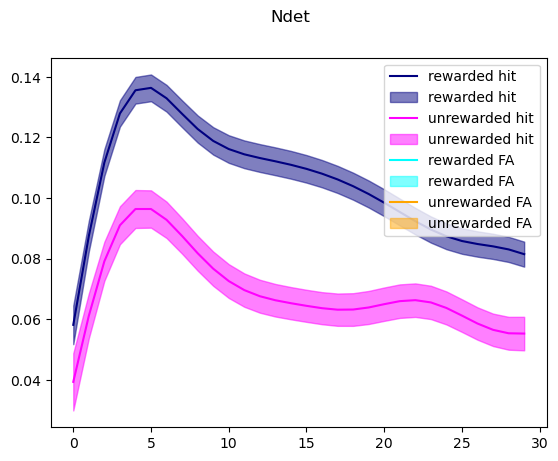

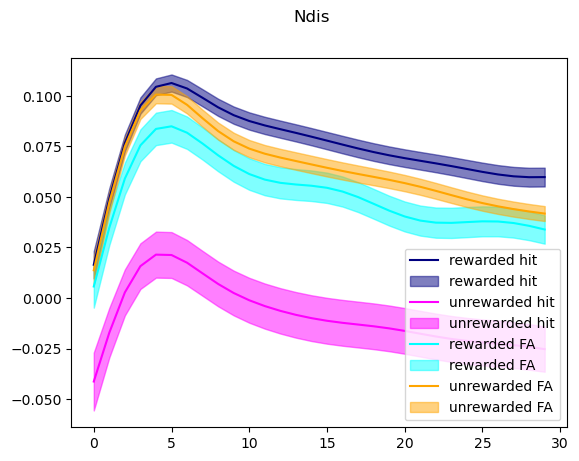

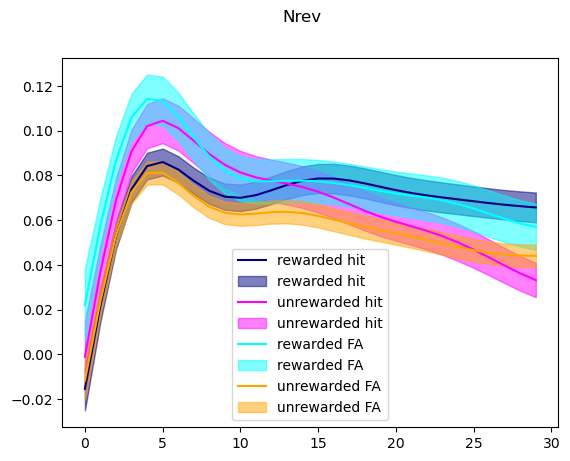

In [10]:
for epoch, epoch_dict in cohort_epochs['events'].items():
    if epoch == 'all':
        epoch_df = pd.concat(epoch_dict)
        
        for soma, soma_list in somas.items():
            if len(soma_list) == 0:
                epoch_df = epoch_df[epoch_df.index.get_level_values(0) != soma]
            else:
                FOV = soma_list[0]
                epoch_df = epoch_df[~((epoch_df.index.get_level_values(0).str.contains(soma)) & (epoch_df['FOV'].str.contains(FOV)))]
        

        deltaF_df = pd.concat(cohort_epochs['deltaF'][epoch])
        deltaF_dfs = []
        for index, rows in deltaF_df.iterrows():
            water = index[12]
            lick = index[7]

            if lick == '-':
                water = 4500
            else:
                if water == '-':
                    water = int(lick)+1000
                else:
                    water = int(water)
            water_fps = math.floor(water/1000*30.3)
            deltaF_dfs.append(rows.iloc[water_fps:water_fps+30].to_numpy())
        deltaF_df = pd.DataFrame(deltaF_dfs, index=deltaF_df.index, columns=list(range(30)))
        
        for protocol in ['Ndet','Ndis', 'Nrev']:
            plt.figure()
            legends = []
            for t, c in zip(['rewarded hit', 'unrewarded hit', 'rewarded FA', 'unrewarded FA'], ['navy','magenta','cyan','orange']):
                ttype_df = deltaF_df[(deltaF_df.index.get_level_values('Final Outcome') == 'Tactile '+t) | (deltaF_df.index.get_level_values('Final Outcome') == 'Auditory '+t)]
                ttype_df = ttype_df[ttype_df.index.get_level_values('Protocol') == protocol]
                ttype_df = ttype_df[ttype_df.index.get_level_values('Channel') == 'Red']
                plt.plot(list(range(30)), ttype_df.mean(), color=c)
                plt.fill_between(list(range(30)), ttype_df.mean()-ttype_df.sem(), ttype_df.mean()+ttype_df.sem(), color=c, alpha=0.5)
                legends.append(t)
                legends.append(t)
            plt.legend(legends)
            plt.suptitle(protocol)


#         correlated_dfs = []
#         for index, rows in epoch_df.iterrows():
#             mouse = index[0]
#             ROI = rows['Unique_ROI']

#             if len(correlated_ROIs[mouse].keys()) > 0:
#                 if ROI in correlated_ROIs[mouse].keys():
#                     correlated_dfs.append(rows.to_frame().T)

#         if len(correlated_dfs) == 0:
#             correlated_df = epoch_df
#         else:
#             correlated_df = pd.concat(correlated_dfs)
#             correlated_df.index.names = correlated_df.index.names

#         for label, df in zip(['ALL_ROIs','correlated_ROIs'],[epoch_df, correlated_df]):
#             if label == 'ALL_ROIs':
#                 epoch_event_rates = []
#                 epoch_event_metrics_list = []
#                 plt.figure()
#                 legends = []
#                 for t in ['rewarded hit', 'unrewarded hit', 'rewarded FA', 'unrewarded FA']:
#                     ttype_events = df[(df['Final Outcome'] == 'Tactile '+t) | (df['Final Outcome'] == 'Auditory '+t)]
#                     ROI_event_count = ttype_events.groupby([ttype_events.index.get_level_values(0), 'Unique_ROI', 'Protocol']).size()
#                     plt.hist(ROI_event_count, alpha=0.5)
#                     legends.append(t)
#                 plt.legend(legends)
#                 ROI_deltaF_df = deltaF_df[deltaF_df.index.get_level_values('Unique_ROI').isin(list(ROI_event_count.index.get_level_values('Unique_ROI')))]
#                 ttype_deltaF = ROI_deltaF_df[ROI_deltaF_df.index.get_level_values('Final Outcome').str.contains(t)]
#                 ROI_trial_count = ttype_deltaF.groupby([ttype_deltaF.index.get_level_values(0), ttype_deltaF.index.get_level_values('Unique_ROI'), ttype_deltaF.index.get_level_values('Protocol')]).size()
#                 ROI_event_rate = ROI_event_count / ROI_trial_count
#                 ROI_event_rate_df = pd.DataFrame(ROI_event_rate.values, index=ROI_event_rate.index, columns=[t])
#                 epoch_event_rates.append(ROI_event_rate_df)
#                 epoch_event_means = ttype_events.groupby([ttype_events.index.get_level_values(0), 'Unique_ROI', 'Final Outcome','Protocol']).mean()

#                 outcome_df = ttype_events.groupby([ttype_events.index.get_level_values(0),ttype_events['Unique_ROI'], ttype_events['Protocol']]).mean().T.reset_index()
#                 outcome_df.index = pd.MultiIndex.from_tuples([(x,y) for x,y in zip(outcome_df['index'], [t]*outcome_df.shape[0])])
#                 outcome_df = outcome_df.T
#                 epoch_event_metrics_list.append(outcome_df)
#             epoch_event_metrics = pd.concat(epoch_event_metrics_list, axis=1).T

#             epoch_event_metric_list = []
#             for metric in ['response latency', 'Prestim licks', 'Anticipatory licks', 'Reward licks', 'Stimulus', 'peak', 'ev_onset', 'peak_time', 'integral']:
#                 metric_df = epoch_event_metrics[epoch_event_metrics.index.get_level_values(0) == metric]
#                 epoch_event_metric_list.append(metric_df)
#             epoch_event_metrics = pd.concat(epoch_event_metric_list).T
#             epoch_event_rate = pd.concat(epoch_event_rates, axis=1)

#             for channel in ['Red','Green']:
#                 channel_epoch_event_rate = epoch_event_rate[epoch_event_rate.index.get_level_values('Unique_ROI').str.contains(channel)]
#                 channel_epoch_event_metrics = epoch_event_metrics[epoch_event_metrics.index.get_level_values('Unique_ROI').str.contains(channel)]

#                 channel_epoch_event_rate.to_csv(('_').join([label,channel,epoch,'event_rate.csv']))
#                 channel_epoch_event_metrics.to_csv(('_').join([label,channel,epoch,'event_metrics.csv']))

## Plotting functions

In [8]:
def plot_pupil(data, epochs, protocols, outcomes, plottype, trials, event_epochs=None):
    data = data['pupil']
    if type(epochs) == str:
        if epochs == 'all':
            epochs = data.keys()
    else:   
        epochs = epochs
        
    for epoch, epoch_dict in data.items():
        if epoch in epochs:
            epoch_df = pd.concat(epoch_dict)
            epoch_df = epoch_df[epoch_df.index.get_level_values('Stimulus') != float(3)]   
            
            if type(protocols) == str:
                if protocols == 'all':
                    protocols = ['N','E'] + list(epoch_df.index.get_level_values('Protocol').unique())
            else:
                protocols = protocols
            
            for protocol in protocols:
                view_outcomes = []
                labels = []
                
                for outcome in outcomes:
                    if (outcomes == ['FA', 'hit']) | (outcomes == ['hit', 'FA']):
                        for label, reward in zip(['rewarded', 'unrewarded'],[float(1), float(0)]):
                            rew_df = epoch_df[epoch_df.index.get_level_values('Water') == reward]
                            out_df = rew_df[rew_df.index.get_level_values('Final Outcome').str.contains(outcome)]
                            view_outcomes.append(out_df)
                            labels.append(label+' '+outcome)
                    else:
                            out_df = epoch_df[epoch_df.index.get_level_values('Final Outcome').str.contains(outcome)]
                            view_outcomes.append(out_df)
                            labels.append(outcome)                            
                
                n = len(view_outcomes)
                fig, ax = plt.subplots(nrows=1, ncols=n, figsize=(5*n,3), sharey=True)
                if plottype == 'trials':
                    color = cm.rainbow(np.linspace(0, 1, n)) 
                    for col, (outcome_df, color, label) in enumerate(zip(view_outcomes, color, labels)):
                        outcome_df = outcome_df[outcome_df.index.get_level_values('Protocol').str.contains(protocol)]
                        
                        if trials == 'events':
                            outcome_df = get_event_trials(outcome_df, 'pupil', event_epochs)
                        else:
                            outcome_df = outcome_df
                        
                        nmice = len(outcome_df.index.get_level_values(0).unique())
                        nsessions = len(outcome_df.index.get_level_values('Unique session').unique())
                        mouse_counts = {}
                        for mouse in outcome_df.index.get_level_values(0).unique():
                            mouse_counts[mouse] = len(outcome_df[outcome_df.index.get_level_values(0) == mouse].index.get_level_values('Unique_trial').unique())
                            
                        unique = outcome_df.groupby(outcome_df.index.get_level_values('Unique_trial')).mean()
                        ntrials = unique.shape[0]
                        mean = unique.mean()
                        sem = unique.sem()
                        ax[col].plot(mean, color=color)
                        ax[col].fill_between(x=list(range(unique.shape[1])), y1=mean-sem, y2=mean+sem, color=color, alpha=0.5)
                        if epoch == 'all':
                            ax[col].set_xticks(np.linspace(0,unique.shape[1],13))
                            ax[col].set_xticklabels([int(x) for x in np.linspace(0,12,13)])      
                        else:
                            ax[col].set_xticks(np.linspace(0,unique.shape[1],11))
                            ax[col].set_xticklabels([str(round(x,1)) for x in np.linspace(0,1,11)])
                        
                        title = str(nsessions)+' sessions/'+str(ntrials)+' trials \n '                     
                        for i, (key, value) in enumerate(mouse_counts.items()):
                            title += ' \n '+key+': '+str(value)+' trials'
                        ax[col].set_title(title)
                        ax[col].legend([label])
                        
                else:
                    legends = []
                    for col, (outcome_df, label) in enumerate(zip(view_outcomes, labels)):
                        outcome_df = outcome_df[outcome_df.index.get_level_values('Protocol').str.contains(protocol)]
                        
                        if trials == 'events':
                            outcome_df = get_event_trials(outcome_df, 'pupil', event_epochs)
                        else:
                            outcome_df = outcome_df
                            
                        nmice = len(list(outcome_df.index.get_level_values(0).unique()))
                        color = cm.rainbow(np.linspace(0,1,nmice))                        
                        unique = outcome_df.groupby(outcome_df.index.get_level_values(0)).mean() 
                        
                        for j, ((color), (index, rows)) in enumerate(zip(color, unique.iterrows())):
                            ax[col].plot(rows, color=ID_colors[index])
                            if epoch == 'all':
                                ax[col].set_xticks(np.linspace(0,unique.shape[1],13))
                                ax[col].set_xticklabels([int(x) for x in np.linspace(0,12,13)])      
                            else:
                                ax[col].set_xticks(np.linspace(0,unique.shape[1],11))
                                ax[col].set_xticklabels([str(round(x,1)) for x in np.linspace(0,1,11)])                
                            ax[col].set_title(label)
                            legends.append(index)
                        ax[col].legend(legends, prop={'size': 6})
                if trials == 'all':
                    plt.suptitle(protocol+' '+epoch+' epoch (Pupil) using all trials', fontsize=25, y=1.5)
                else:
                    plt.suptitle(protocol+' '+epoch+' epoch (Pupil) using only trials with '+event_epochs+' events', fontsize=25, y=1.5)
                plt.ylim(0.94,1.2)
                fig.savefig(protocol+'_pupil.svg')

In [9]:
def plot_calcium(data, channel, epochs, protocols, outcomes, plottype, trials, event_epochs=None):
    data = data['deltaF']

    if type(epochs) == str:
        if epochs == 'all':
            data.keys()
    else:   
        epochs = epochs
        
    for epoch, epoch_dict in data.items():
        if epoch in epochs:
            epoch_df = pd.concat(epoch_dict)
            epoch_df = epoch_df[epoch_df.index.get_level_values('Stimulus') != float(3)]  
            
            groups = epoch_df.groupby(epoch_df.index.get_level_values(0))
            for group in epoch_df.index.get_level_values(0).unique():
                group_df = groups.get_group(group)
            epoch_df = epoch_df[epoch_df.index.get_level_values('Channel') == channel]
            
            if channel == 'Green':
                epoch_df = epoch_df
            else:
                for soma, soma_list in somas.items():
                    if len(soma_list) == 0:
                        epoch_df = epoch_df[epoch_df.index.get_level_values(0) != soma]
                    else:
                        FOV = soma_list[0]
                        epoch_df = epoch_df[~((epoch_df.index.get_level_values(0).str.contains(soma)) & (epoch_df.index.get_level_values('FOV').str.contains(FOV)))]
            
            if type(protocols) == str:
                if protocols == 'all':
                    protocols = ['N','E'] + list(epoch_df.index.get_level_values('Protocol').unique())
            else:
                protocols = protocols
            
            for protocol in protocols:
                view_outcomes = []
                labels = []
                for outcome in outcomes:
                    if (outcomes == ['FA', 'hit']) | (outcomes == ['hit', 'FA']):
                        if epoch in ['reward', 'ITI', 'delayed_reward', 'all']:
                            for label, reward in zip(['rewarded', 'unrewarded'],[float(1), float(0)]):
                                rew_df = epoch_df[epoch_df.index.get_level_values('Water') == reward]
                                out_df = rew_df[rew_df.index.get_level_values('Final Outcome').str.contains(outcome)]
                                view_outcomes.append(out_df)
                                labels.append(label+' '+outcome)
                        else:
                            out_df = epoch_df[epoch_df.index.get_level_values('Final Outcome').str.contains(outcome)]
                            view_outcomes.append(out_df)
                            labels.append(outcome)     
                    elif outcome == 'rewarded':
                        out_df = epoch_df[epoch_df.index.get_level_values('Water') == float(1)]
                        view_outcomes.append(out_df)
                        labels.append(outcome)   
                    elif outcome == 'unrewarded':                        
                        out_df = epoch_df[epoch_df.index.get_level_values('Water') == float(0)]
                        view_outcomes.append(out_df)
                        labels.append(outcome)                           
                    else:
                            out_df = epoch_df[epoch_df.index.get_level_values('Final Outcome').str.contains(outcome)]
                            view_outcomes.append(out_df)
                            labels.append(outcome)                   
                n = len(view_outcomes)
                fig, ax = plt.subplots(nrows=1, ncols=n, figsize=(5*n,3), sharey=True)
                if plottype == 'ROIs':
                    color = cm.rainbow(np.linspace(0, 1, n)) 
                    for col, (outcome_df, color, label) in enumerate(zip(view_outcomes, color, labels)):
                        if protocol =='E2':
                            outcome_df = outcome_df[(outcome_df.index.get_level_values('Protocol') == 'Edis') | (outcome_df.index.get_level_values('Protocol') == 'Erev')]
                        elif protocol =='N2':
                            outcome_df = outcome_df[(outcome_df.index.get_level_values('Protocol') == 'Ndis') | (outcome_df.index.get_level_values('Protocol') == 'Nrev')]
                        elif protocol == 'dynamic':
                            outcome_df = outcome_df          
                        elif protocol == 'stable':
                            outcome_df = outcome_df
                        else:
                            outcome_df = outcome_df[outcome_df.index.get_level_values('Protocol').str.contains(protocol)]
                        
#                         if protocol == 'dynamic':
#                             outcome_dfs = []
#                             sessions = outcome_df.groupby(outcome_df.index.get_level_values('Unique session'))
#                             for sesh in outcome_df.index.get_level_values('Unique session').unique():
#                                 shortened_sesh = sesh.split('FOV')[0][:-1]
#                                 sesh_df = sessions.get_group(sesh)
#                                 check_ID = sesh_df.index.get_level_values(0)[0]
#                                 for dysesh in short_term_strategy:
#                                     if (check_ID in dysesh) & (shortened_sesh in dysesh) & ('PUPIL' not in dysesh):
#                                         outcome_dfs.append(sesh_df)
#                             outcome_df = pd.concat(outcome_dfs)
#                         elif protocol == 'stable':
#                             dynamic_seshes = []
#                             sessions = outcome_df.groupby(outcome_df.index.get_level_values('Unique session'))
#                             for sesh in outcome_df.index.get_level_values('Unique session').unique():
#                                 shortened_sesh = sesh.split('FOV')[0][:-1]
#                                 sesh_df = sessions.get_group(sesh)
#                                 check_ID = sesh_df.index.get_level_values(0)[0]
#                                 for dysesh in short_term_strategy:
#                                     if (check_ID in dysesh) & (shortened_sesh in dysesh) & ('PUPIL' not in dysesh):
#                                         dynamic_seshes.append(sesh)

#                             outcome_dfs = []
#                             for sesh in outcome_df.index.get_level_values('Unique session').unique():
#                                 sesh_df = sessions.get_group(sesh)
#                                 if sesh in dynamic_seshes:
#                                     None
#                                 else:
#                                     outcome_dfs.append(sesh_df)
#                             outcome_df = pd.concat(outcome_dfs)
#                         else:
#                             outcome_df = outcome_df  
                            
                        if trials == 'events':
                            outcome_df = get_event_trials(outcome_df, 'deltaF', event_epochs)
                        else:
                            outcome_df = outcome_df
                        
                        mouse_counts = {}
                        
                        for mouse in outcome_df.index.get_level_values(0).unique():
                            mouse_counts[mouse] = len(outcome_df[outcome_df.index.get_level_values(0) == mouse].index.get_level_values('Unique_ROI').unique())
                            
                        nmice = len(outcome_df.index.get_level_values(0).unique())
                        nsessions = len(outcome_df.index.get_level_values('Unique session').unique())
                        
                        unique = outcome_df.groupby(outcome_df.index.get_level_values('Unique_ROI')).mean()
                        nROIs = unique.shape[0]
                        mean = unique.mean()
                        sem = unique.sem()
                        ax[col].plot(mean, color=color)
                        ax[col].fill_between(x=list(range(unique.shape[1])), y1=mean-sem, y2=mean+sem, color=color, alpha=0.5)
                        
                        if epoch == 'all':
                            ax[col].set_xticks(np.linspace(0,unique.shape[1],13))
                            ax[col].set_xticklabels([int(x) for x in np.linspace(0,12,13)])      
                        else:
                            ax[col].set_xticks(np.linspace(0,unique.shape[1],11))
                            ax[col].set_xticklabels([str(round(x,1)) for x in np.linspace(0,1,11)])
                        title = str(nsessions)+' sessions/'+str(nROIs)+' ROIs \n '
                        
                        for i, (key, value) in enumerate(mouse_counts.items()):
                            title += ' \n '+key+': '+str(value)+' ROIs'
                        ax[col].set_title(title)
                        ax[col].legend([label])
                elif plottype == 'mice':
                    legends = []
                    for col, (outcome_df, label) in enumerate(zip(view_outcomes, labels)):
                        if protocol =='E2':
                            outcome_df = outcome_df[(outcome_df.index.get_level_values('Protocol') == 'Edis') | (outcome_df.index.get_level_values('Protocol') == 'Erev')]
                        elif protocol =='N2':
                            outcome_df = outcome_df[(outcome_df.index.get_level_values('Protocol') == 'Ndis') | (outcome_df.index.get_level_values('Protocol') == 'Nrev')]
                        else:
                            outcome_df = outcome_df[outcome_df.index.get_level_values('Protocol').str.contains(protocol)]                        
                        
                        if trials == 'events':
                            outcome_df = get_event_trials(outcome_df, 'deltaF', event_epochs)
                        else:
                            outcome_df = outcome_df
                            
                        nmice = len(list(outcome_df.index.get_level_values(0).unique()))
                        color = cm.rainbow(np.linspace(0,1,nmice))                        
                        unique = outcome_df.groupby(outcome_df.index.get_level_values(0)).mean() 
                        
                        for j, ((color), (index, rows)) in enumerate(zip(color, unique.iterrows())):
                            ax[col].plot(rows, color=ID_colors[index])
                            if epoch == 'all':
                                ax[col].set_xticks(np.linspace(0,unique.shape[1],13))
                                ax[col].set_xticklabels([int(x) for x in np.linspace(0,12,13)])      
                            else:
                                ax[col].set_xticks(np.linspace(0,unique.shape[1],11))
                                ax[col].set_xticklabels([str(round(x,1)) for x in np.linspace(0,1,11)])              
                            ax[col].set_title(label)
                            legends.append(index)
                        ax[col].legend(legends, prop={'size': 6})
                else:
                    color = cm.rainbow(np.linspace(0, 1, n)) 
                    for col, (uncorrelated_df, color, label) in enumerate(zip(view_outcomes, color, labels)):
                        if protocol =='E2':
                            uncorrelated_df = uncorrelated_df[(uncorrelated_df.index.get_level_values('Protocol') == 'Edis') | (uncorrelated_df.index.get_level_values('Protocol') == 'Erev')]
                        elif protocol =='N2':
                            uncorrelated_df = uncorrelated_df[(uncorrelated_df.index.get_level_values('Protocol') == 'Ndis') | (uncorrelated_df.index.get_level_values('Protocol') == 'Nrev')]
                        elif protocol == 'dynamic':
                            uncorrelated_df = uncorrelated_df          
                        elif protocol == 'stable':
                            uncorrelated_df = uncorrelated_df
                        else:
                            uncorrelated_df = uncorrelated_df[uncorrelated_df.index.get_level_values('Protocol').str.contains(protocol)]
                        
#                         if protocol == 'dynamic':
#                             uncorrelated_dfs = []
#                             sessions = uncorrelated_df.groupby(uncorrelated_df.index.get_level_values('Unique session'))
#                             for sesh in uncorrelated_df.index.get_level_values('Unique session').unique():
#                                 shortened_sesh = sesh.split('FOV')[0][:-1]
#                                 sesh_df = sessions.get_group(sesh)
#                                 check_ID = sesh_df.index.get_level_values(0)[0]
#                                 for dysesh in short_term_strategy:
#                                     if (check_ID in dysesh) & (shortened_sesh in dysesh) & ('PUPIL' not in dysesh):
#                                         uncorrelated_dfs.append(sesh_df)
#                             uncorrelated_df = pd.concat(uncorrelated_dfs)
#                         elif protocol == 'stable':
#                             dynamic_seshes = []
#                             sessions = uncorrelated_df.groupby(uncorrelated_df.index.get_level_values('Unique session'))
#                             for sesh in uncorrelated_df.index.get_level_values('Unique session').unique():
#                                 shortened_sesh = sesh.split('FOV')[0][:-1]
#                                 sesh_df = sessions.get_group(sesh)
#                                 check_ID = sesh_df.index.get_level_values(0)[0]
#                                 for dysesh in short_term_strategy:
#                                     if (check_ID in dysesh) & (shortened_sesh in dysesh) & ('PUPIL' not in dysesh):
#                                         dynamic_seshes.append(sesh)

#                             uncorrelated_dfs = []
#                             for sesh in uncorrelated_df.index.get_level_values('Unique session').unique():
#                                 sesh_df = sessions.get_group(sesh)
#                                 if sesh in dynamic_seshes:
#                                     None
#                                 else:
#                                     uncorrelated_dfs.append(sesh_df)
#                             uncorrelated_df = pd.concat(uncorrelated_dfs)
#                         else:
#                             uncorrelated_df = uncorrelated_df                         
                        
                        outcome_dfs = []
                        for index, rows in uncorrelated_df.iterrows():
                            mouse = index[0]
                            ROI = index[19]
                            
                            if len(correlated_ROIs[mouse].keys()) > 0:
                                if ROI in correlated_ROIs[mouse].keys():
                                    outcome_dfs.append(rows.to_frame().T)
                        
                        if len(outcome_dfs) == 0:
                            None
                        else:
                            outcome_df = pd.concat(outcome_dfs)
                            outcome_df.index.names = uncorrelated_df.index.names

                            if trials == 'events':
                                outcome_df = get_event_trials(outcome_df, 'deltaF', event_epochs)
                            else:
                                outcome_df = outcome_df

                            mouse_counts = {}

                            for mouse in outcome_df.index.get_level_values(0).unique():
                                mouse_counts[mouse] = len(outcome_df[outcome_df.index.get_level_values(0) == mouse].index.get_level_values('Unique_ROI').unique())

                            nmice = len(outcome_df.index.get_level_values(0).unique())
                            nsessions = len(outcome_df.index.get_level_values('Unique session').unique())

                            unique = outcome_df.groupby(outcome_df.index.get_level_values('Unique_ROI')).mean()
                            nROIs = unique.shape[0]
                            mean = unique.mean()
                            sem = unique.sem()
                            ax[col].plot(mean, color=color)
                            ax[col].fill_between(x=list(range(unique.shape[1])), y1=mean-sem, y2=mean+sem, color=color, alpha=0.5)

                            if epoch == 'all':
                                ax[col].set_xticks(np.linspace(0,unique.shape[1],13))
                                ax[col].set_xticklabels([int(x) for x in np.linspace(0,12,13)])      
                            else:
                                ax[col].set_xticks(np.linspace(0,unique.shape[1],11))
                                ax[col].set_xticklabels([str(round(x,1)) for x in np.linspace(0,1,11)])
                            title = str(nsessions)+' sessions/'+str(nROIs)+' ROIs \n '

                            for i, (key, value) in enumerate(mouse_counts.items()):
                                title += ' \n '+key+': '+str(value)+' ROIs'
                            ax[col].set_title(title)
                            ax[col].legend([label])                    
                if trials == 'all':
                    if plottype == 'ROIs':
                        plt.suptitle(protocol+' '+epoch+' epoch ('+channel+') using all trials and all ROIs', fontsize=25, y=1.5)
                    elif plottype == 'correlated_ROIs':
                        plt.suptitle(protocol+' '+epoch+' epoch ('+channel+') using all trials and correlated ROIs only', fontsize=25, y=1.5)                        
                else:
                    if plottype == 'ROIs':
                        plt.suptitle(protocol+' '+epoch+' epoch ('+channel+') using only trials with '+event_epochs+' events and all ROIs', fontsize=25, y=1.5)
                    elif plottype == 'correlated_ROIs':
                        plt.suptitle(protocol+' '+epoch+' epoch ('+channel+') using only trials with '+event_epochs+' events and correlated ROIs only', fontsize=25, y=1.5)                        

In [10]:
def get_event_trials(data, dtype, epoch):
    events = pd.concat(cohort_epochs['events'][epoch])
    events = events.droplevel(1)
    
    if dtype == 'pupil':
        events['Date'] = [int(x) for x in list(events['Date'])]
        IDs = pd.DataFrame([events.index], index=['mouse_ID']).T
        midx = events.iloc[:,0:19].reset_index().iloc[:,1:]
        final_outcomes = events['Final Outcome'].to_frame().reset_index().iloc[:,1:]
        new_midx = pd.concat([IDs, midx, final_outcomes], axis=1)
        events.index = pd.MultiIndex.from_tuples(tuple(np.asarray(new_midx)))
        events = events.droplevel([6,19])
    else:      
        IDs = pd.DataFrame([events.index], index=['mouse_ID']).T
        midx = events.iloc[:,0:19].reset_index().iloc[:,1:]
        final_outcomes = events['Final Outcome'].to_frame().reset_index().iloc[:,1:]
        new_midx = pd.concat([IDs, midx, final_outcomes], axis=1)
        events.index = pd.MultiIndex.from_tuples(tuple(np.asarray(new_midx)))
    events.index.names = pd.concat(cohort_epochs[dtype]['reward']).index.names 
    idx = data.index.intersection(events.index)
    event_trials = data.loc[idx]
    
    return event_trials

In [15]:
def plot_and_extract_correlated_ROIs(cohort_correlations, cohort_events, cohort_deltaF, r_thresh, event_thresh):
    fname = 'correlated_ROIs_'+str(r_thresh)+'rthresh_'+str(event_thresh)+'eventthresh'
    
    if fname+'.pdf' in os.listdir(cwd):
        print(fname+'.pdf already exists')
    else:
        pdf = matplotlib.backends.backend_pdf.PdfPages(fname+'.pdf')
        correlated_ROIs = {}
        for mouse, mouse_dict in cohort_correlations.items():
            correlated_ROIs[mouse] = {}
            if 'cross-pairs' in mouse_dict.keys():
                for session, session_dict in mouse_dict['cross-pairs'].items():
                    session_split = session.split('_')
                    FPS = cohort_params[mouse][session_split[0]][session_split[1]][session_split[2]]['FPS']
                    for ROI, ROI_dict in session_dict.items():

                        mouse_df = cohort_deltaF[mouse]
                        ROI_df = mouse_df[mouse_df.index.get_level_values('Unique_ROI') == ROI]
                        trials = ROI_df.index.get_level_values('Trial')
                        ROI_df = (ROI_df - ROI_df.min().min()) / (ROI_df.max().max() - ROI_df.min().min())
                        ROI_flat = ROI_df.to_numpy().flatten()


                        mouse_events = cohort_events[mouse]
                        ROI_events = mouse_events[mouse_events['Unique_ROI'] == ROI]

                        ROI_peak_times = []
                        for index, rows in ROI_events.iterrows():
                            trial_idx = np.where(np.asarray(trials) == rows.Trial)[0][0]
                            peak_time = (trial_idx*ROI_df.shape[1]) + (rows['peak_time']*FPS)
                            ROI_peak_times.append(peak_time) if peak_time < ROI_flat.shape[0] else None
                        ROI_peaks = [ROI_flat[math.ceil(x)] for x in ROI_peak_times]

                        ROI_color = 'green' if 'Green' in ROI else 'red'
                        ROI_label = ('_').join(ROI.split('_')[-2:])
                        for partner, r in ROI_dict.items():
                            if r > r_thresh:
                                partner_df = mouse_df[mouse_df.index.get_level_values('Unique_ROI') == partner]
                                partner_df = (partner_df - partner_df.min().min()) / (partner_df.max().max() - partner_df.min().min())
                                partner_flat = partner_df.to_numpy().flatten()
                                partner_flat = partner_flat-0.75

                                partner_events = mouse_events[mouse_events['Unique_ROI'] == partner]
                                partner_peak_times = []
                                for index, rows in partner_events.iterrows():
                                    trial_idx = np.where(np.asarray(trials) == rows.Trial)[0][0]
                                    peak_time = (trial_idx*partner_df.shape[1]) + (rows['peak_time']*FPS)
                                    partner_peak_times.append(peak_time) if peak_time < partner_flat.shape[0] else None
                                partner_peaks = [partner_flat[math.ceil(x)] for x in partner_peak_times]

                                partner_color = 'green' if 'Green' in partner else 'red'
                                partner_label = ('_').join(partner.split('_')[-2:])

                                matched_event_times = []
                                matched_event_peaks = []
                                for ROI_time, ROI_peak in zip(ROI_peak_times, ROI_peaks):
                                    for partner_time in partner_peak_times:
                                        if distance(ROI_time, partner_time) < 15:
                                            matched_event_times.append(ROI_time)
                                            matched_event_peaks.append(ROI_peak+0.1)
                                            
                                event_ratio = len(matched_event_times) / len(ROI_peak_times)
                                if event_ratio > event_thresh:
                                    if ROI not in correlated_ROIs[mouse].keys():
                                        correlated_ROIs[mouse][ROI] = {}
                                        correlated_ROIs[mouse][ROI][partner] = {'r':r, 'event_ratio':event_ratio}
                                    else:
                                        correlated_ROIs[mouse][ROI][partner] = {'r':r, 'event_ratio':event_ratio}
                                   
                                    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20,4))
                                    fig.suptitle(mouse+'_'+session+' \n '+ROI_label, fontsize=25, y=0.98)
                                    ax.plot(partner_flat, color=partner_color, alpha=0.3)
                                    ax.plot(ROI_flat, color=ROI_color,alpha=0.3)

                                    ax.scatter(y=ROI_peaks, x=ROI_peak_times, color=ROI_color, marker='*', s=15)
                                    ax.scatter(y=partner_peaks, x=partner_peak_times, color=partner_color, marker='*', s=15)
                                    ax.scatter(y=matched_event_peaks, x=matched_event_times, color='orange', marker='*', s=25)

                                    ax.set_title(partner_label, fontsize=15)  
                                    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
                                    pdf.savefig(fig)
        np.save(fname+'.npy', correlated_ROIs)
        pdf.close()

## Time to visualize

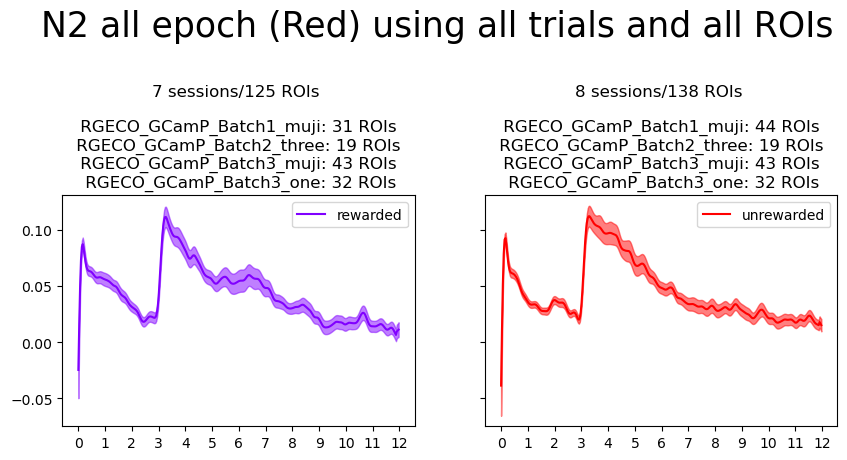

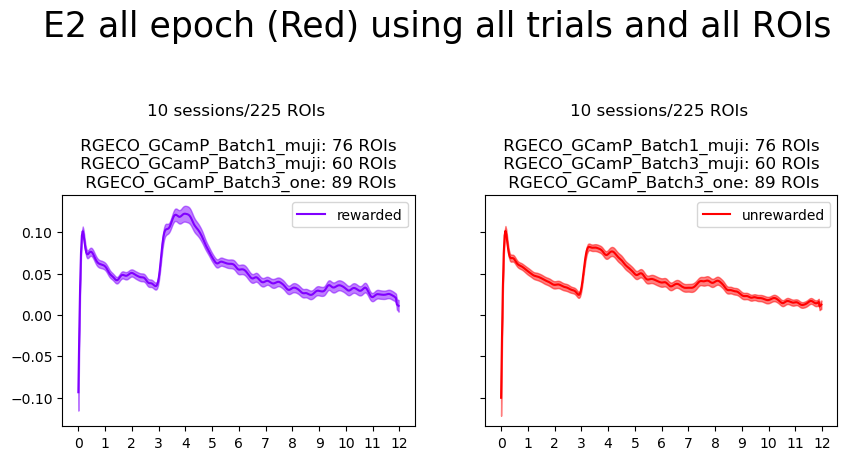

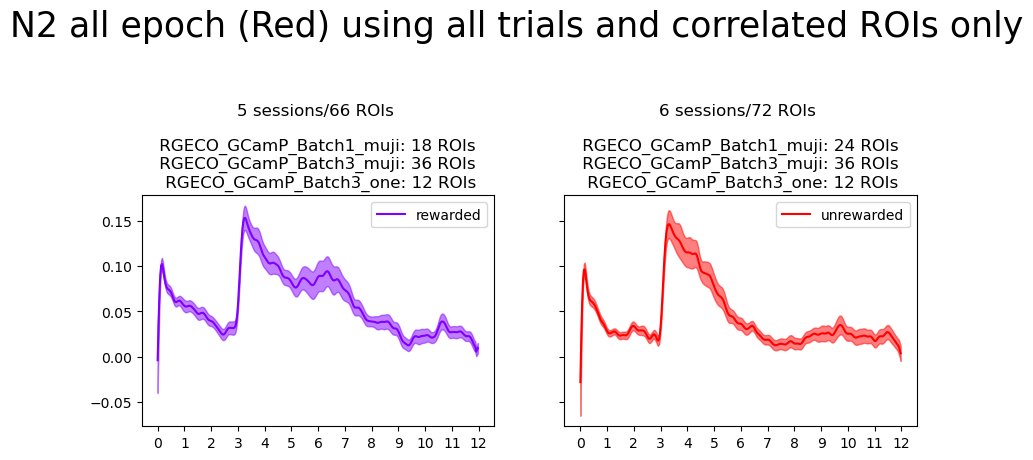

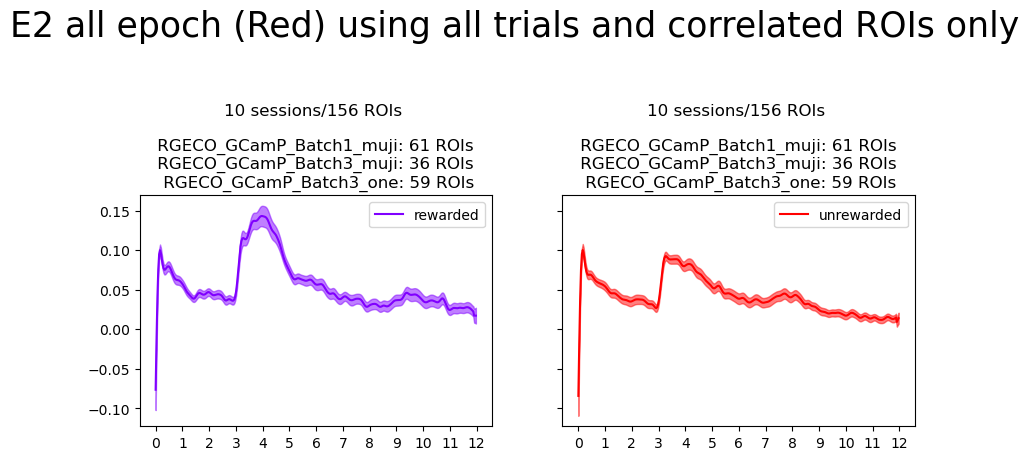

In [55]:
# plot_calcium(cohort_epochs, channel='Red', epochs=['all'] ,protocols=['Ndis', 'Nrev', 'Edis', 'Erev'], outcomes=['hit','FA'], plottype='correlated_ROIs', trials='all', event_epochs='reward')
# plot_calcium(cohort_epochs, channel='Red', epochs=['all'] ,protocols=['Ndis','Edis'], outcomes=['hit','FA'], plottype='ROIs', trials='all', event_epochs='reward')
plot_calcium(cohort_epochs, channel='Red', epochs=['all'] ,protocols=['N2','E2'], outcomes=['rewarded','unrewarded'], plottype='ROIs', trials='all', event_epochs='reward')
plot_calcium(cohort_epochs, channel='Red', epochs=['all'] ,protocols=['N2','E2'], outcomes=['rewarded','unrewarded'], plottype='correlated_ROIs', trials='all', event_epochs='reward')

# plot_calcium(cohort_epochs, channel='Green', epochs=['all'] ,protocols=['N','E'], outcomes=['hit','FA'], plottype='ROIs', trials='all', event_epochs='evnts')
# plot_calcium(cohort_epochs, channel='Red', epochs=['all'] ,protocols=['N'], outcomes=['hit','FA'], plottype='ROIs', trials='events', event_epochs='ITI')
# plot_calcium(cohort_epochs, channel='Red', epochs=['all'] ,protocols=['N'], outcomes=['hit','FA'], plottype='correlated_ROIs', trials='all', event_epochs='ITI')
# plot_pupil(cohort_epochs, epochs=['ITI'] ,protocols=['Ndet','Edet','Ndis','Edis','Nrev','Erev'], outcomes=['hit','FA'], plottype='trials', trials='all', event_epochs='reward')

In [247]:
outcome_df = pd.concat(cohort_epochs['deltaF']['all'])
outcome_dfs = []
sessions = outcome_df.groupby(outcome_df.index.get_level_values('Unique session'))
for sesh in outcome_df.index.get_level_values('Unique session').unique():
    shortened_sesh = sesh.split('FOV')[0][:-1]
    sesh_df = sessions.get_group(sesh)
    check_ID = sesh_df.index.get_level_values(0)[0]
    for dysesh in short_term_strategy:
        if (check_ID in dysesh) & (shortened_sesh in dysesh) & ('PUPIL' not in dysesh):
            outcome_dfs.append(sesh_df)
test = pd.concat(outcome_dfs)

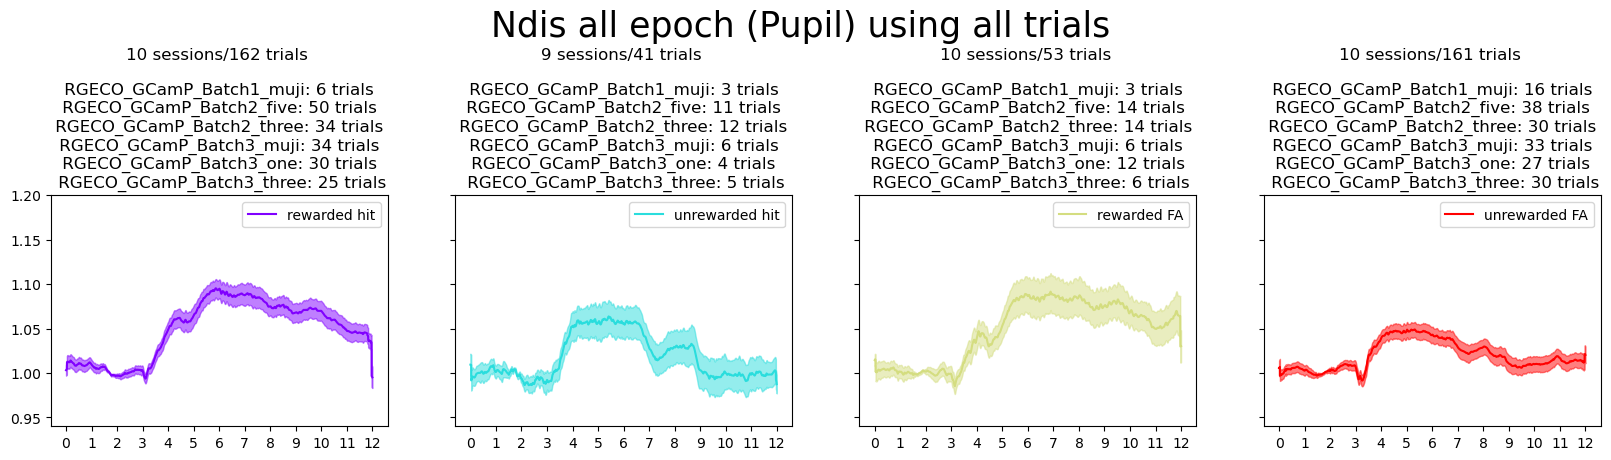

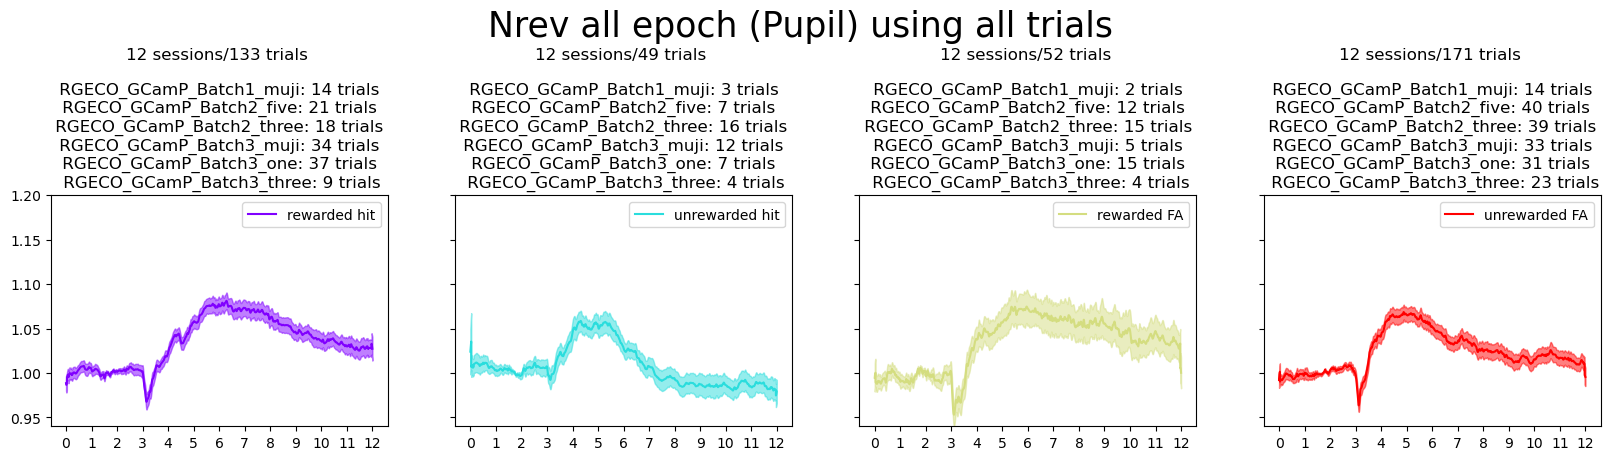

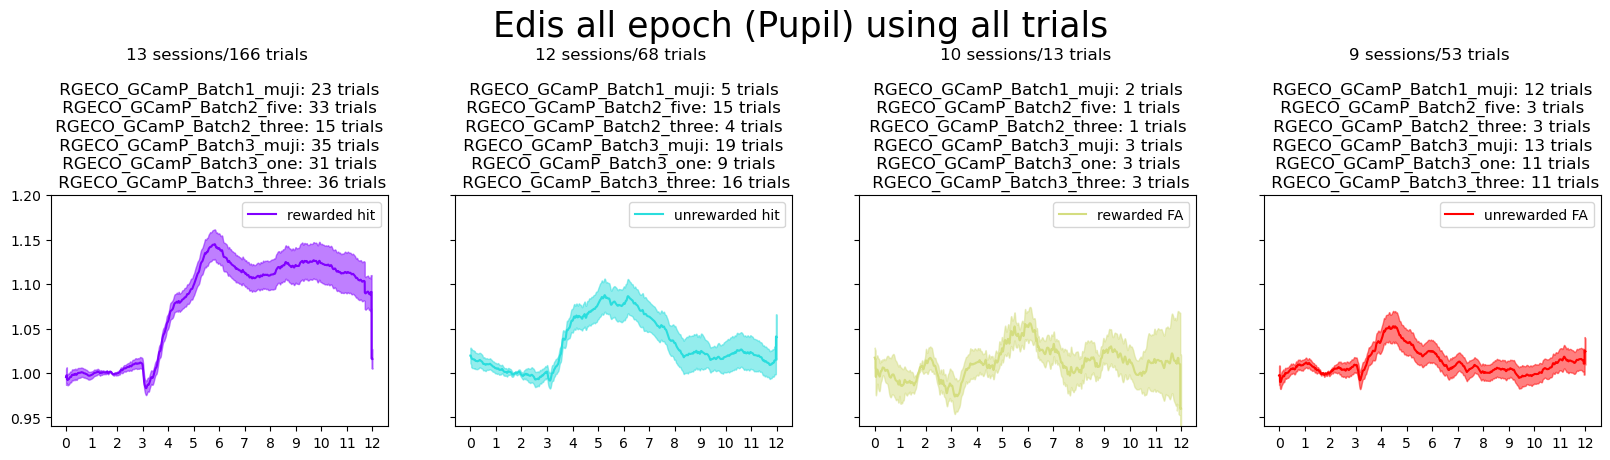

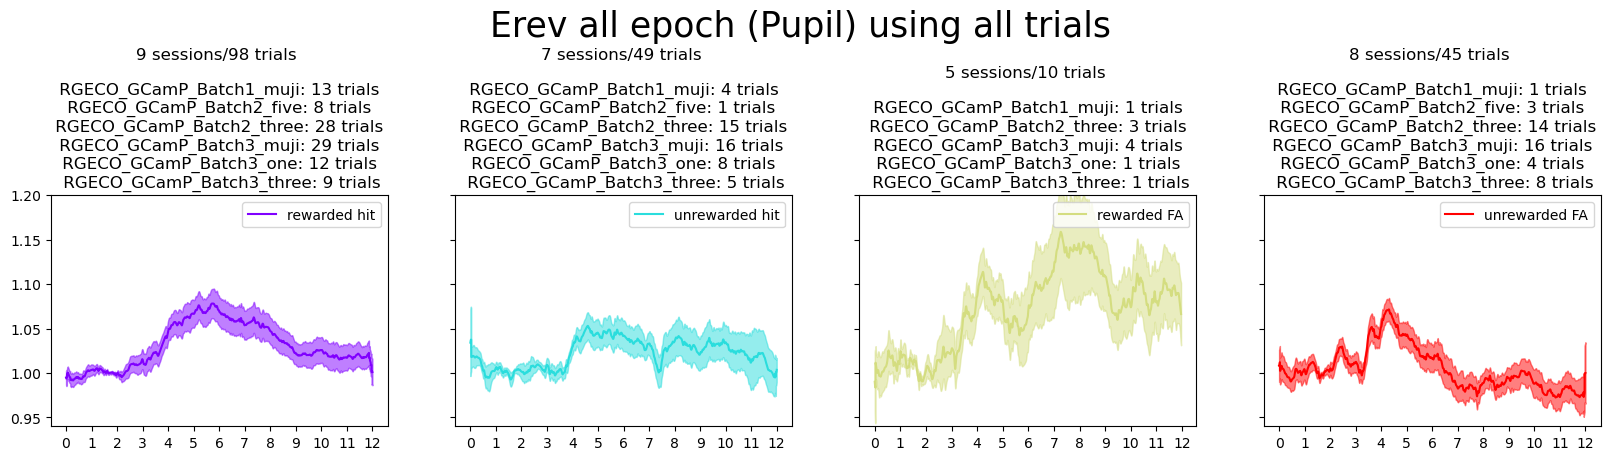

In [15]:
# plot_calcium(cohort_epochs, channel='Red', epochs=['all'] ,protocols=['N'], outcomes=['hit','FA'], plottype='ROIs', trials='all', event_epochs='reward')
# plot_calcium(cohort_epochs, channel='Red', epochs=['all'] ,protocols=['N'], outcomes=['hit','FA'], plottype='ROIs', trials='events', event_epochs='reward')
# plot_calcium(cohort_epochs, channel='Red', epochs=['all'] ,protocols=['N'], outcomes=['hit','FA'], plottype='correlated_ROIs', trials='all', event_epochs='reward')
plot_pupil(cohort_epochs, epochs=['all'] ,protocols=['Ndis','Nrev'], outcomes=['hit','FA'], plottype='trials', trials='all', event_epochs='reward')
plot_pupil(cohort_epochs, epochs=['all'] ,protocols=['Edis','Erev'], outcomes=['hit','FA'], plottype='trials', trials='all', event_epochs='reward')

In [173]:
test = outcome_df.groupby([outcome_df.index.get_level_values(0), outcome_df.index.get_level_values('Unique session')]).mean()
test[test.index.get_level_values(0) == 'RGECO_GCamP_Batch3_one']

0         1         2    \
                       Unique session                                        
RGECO_GCamP_Batch3_one Edet_230101_FOV1.EDET -0.028828  0.046849  0.110191   
                       Edis_230104_FOV1.1     0.107684  0.162992  0.209513   
                       Erev_230108_FOV1.1     0.128427  0.184490  0.231555   
                       Ndet_221229_FOV1.1     0.076951  0.101805  0.122501   
                       Ndis_230101_FOV1.NDIS  0.035218  0.088840  0.133529   
                       Nrev_230105_FOV1.1     0.275512  0.291986  0.305344   
                       Nrev_230105_FOV1.2     0.415092  0.421177  0.425892   

                                                   3         4         5    \
                       Unique session                                        
RGECO_GCamP_Batch3_one Edet_230101_FOV1.EDET  0.153524  0.175678  0.180702   
                       Edis_230104_FOV1.1     0.241768  0.258857  0.263534   
                       Erev_230108_FOV1.1     0.264081  0.281319  0.286303   
                       Ndet_221229_FOV1.1     0.136485  0.143363  0.144424   
                       Ndis_230101_FOV1.NDIS  0.163777  0.178840  0.181751   
                       Nrev_230105_FOV1.1     0.313736  0.317032  0.316468   
                       Nrev_230105_FOV1.2     0.428405  0.428603  0.426907   

                                                   6         7         8    \
                       Unique session                                        
RGECO_GCamP_Batch3_one Edet_230101_FOV1.EDET  0.175056  0.164991  0.154988   
                       Edis_230104_FOV1.1     0.260245  0.253365  0.246143   
                       Erev_230108_FOV1.1     0.283733  0.278045  0.272316   
                       Ndet_221229_FOV1.1     0.141739  0.137387  0.132964   
                       Ndis_230101_FOV1.NDIS  0.177225  0.169741  0.162434   
                       Nrev_230105_FOV1.1     0.313898  0.311050  0.308991   
                       Nrev_230105_FOV1.2     0.423985  0.420564  0.417317   

                                                   9    ...       357  \
                       Unique session                   ...             
RGECO_GCamP_Batch3_one Edet_230101_FOV1.EDET  0.147317  ...  0.047695   
                       Edis_230104_FOV1.1     0.240369  ...  0.113462   
                       Erev_230108_FOV1.1     0.268043  ...  0.137159   
                       Ndet_221229_FOV1.1     0.129368  ...  0.064101   
                       Ndis_230101_FOV1.NDIS  0.156841  ...  0.079761   
                       Nrev_230105_FOV1.1     0.307962  ...  0.282992   
                       Nrev_230105_FOV1.2     0.414717  ...  0.185600   

                                                   358       359       360  \
                       Unique session                                        
RGECO_GCamP_Batch3_one Edet_230101_FOV1.EDET  0.048756  0.049896  0.051143   
                       Edis_230104_FOV1.1     0.112223  0.111039  0.110204   
                       Erev_230108_FOV1.1     0.137745  0.138199  0.138439   
                       Ndet_221229_FOV1.1     0.063249  0.062706  0.062566   
                       Ndis_230101_FOV1.NDIS  0.079551  0.080012  0.081061   
                       Nrev_230105_FOV1.1     0.282485  0.281754  0.280959   
                       Nrev_230105_FOV1.2     0.185835  0.186257  0.186860   

                                                   361       362       363  \
                       Unique session                                        
RGECO_GCamP_Batch3_one Edet_230101_FOV1.EDET  0.052456  0.053730  0.054835   
                       Edis_230104_FOV1.1     0.109873  0.110017  0.110477   
                       Erev_230108_FOV1.1     0.138532  0.138669  0.139063   
                       Ndet_221229_FOV1.1     0.062734  0.062949  0.062934   
                       Ndis_230101_FOV1.NDIS  0.082366  0.083470  0.083964   
                       Nrev_230105_

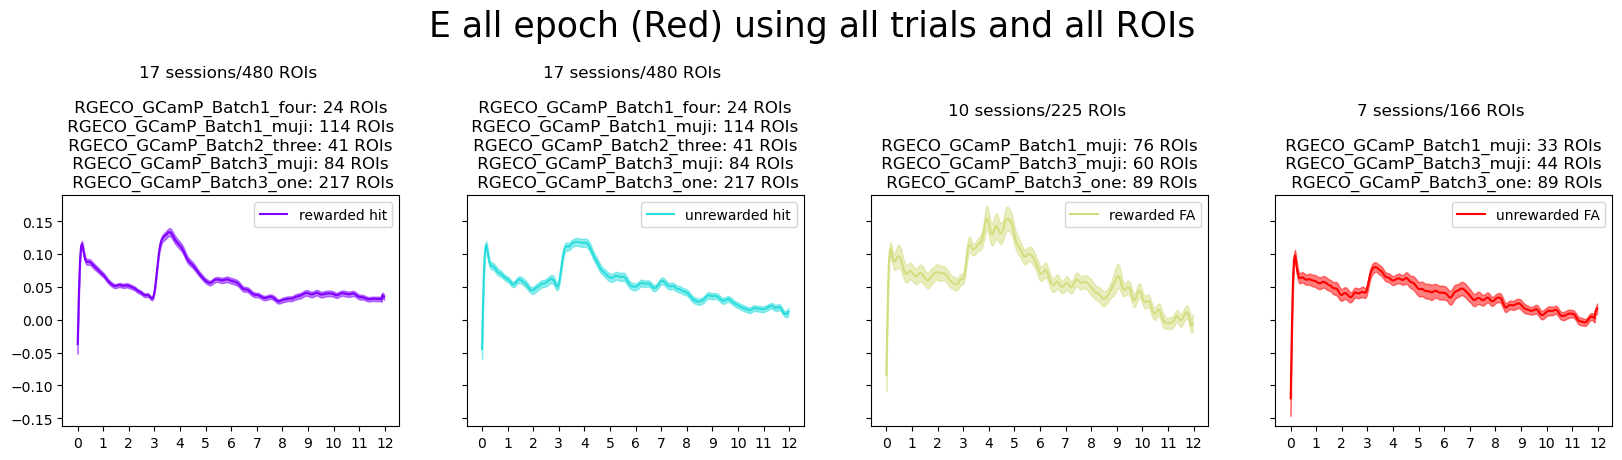

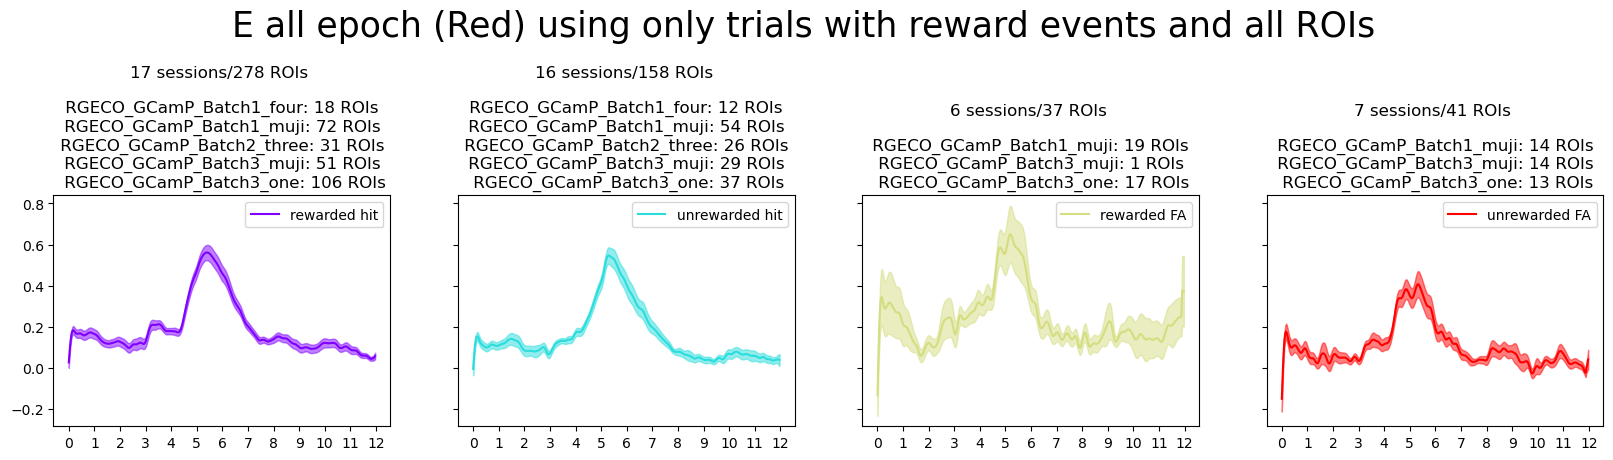

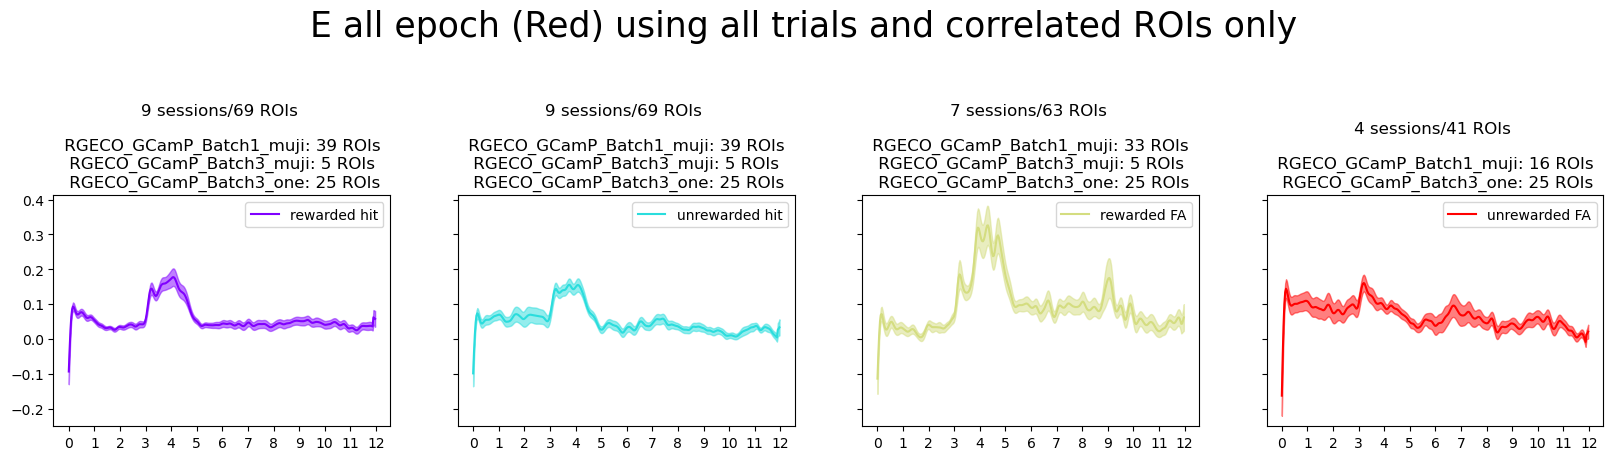

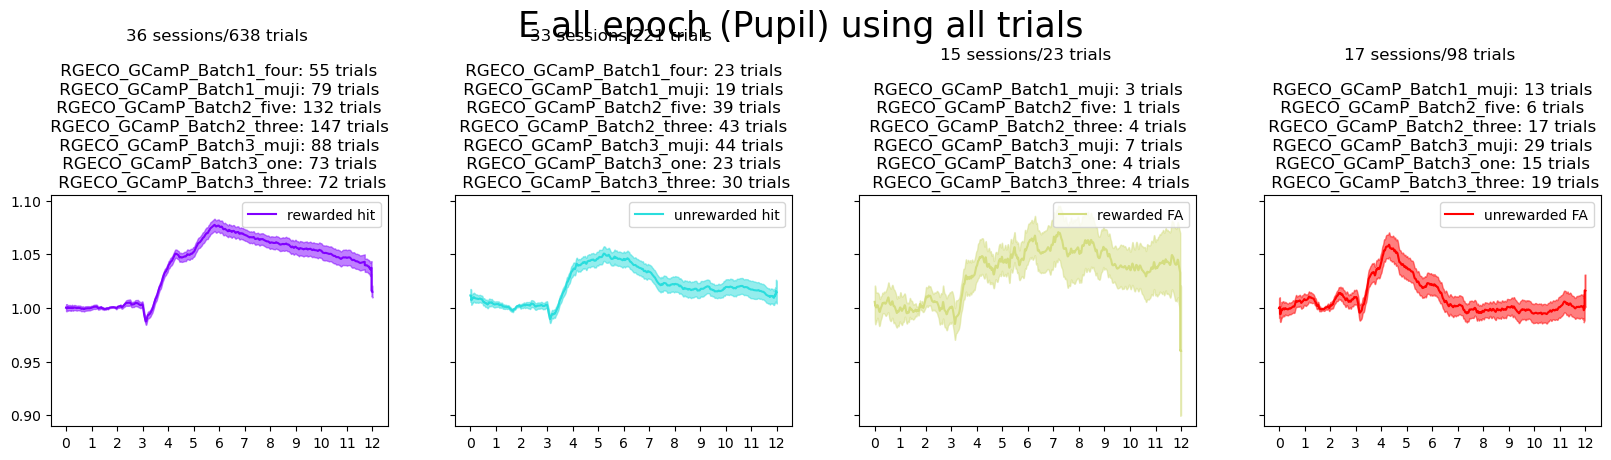

In [43]:
plot_calcium(cohort_epochs, channel='Red', epochs=['all'] ,protocols=['E'], outcomes=['hit','FA'], plottype='ROIs', trials='all', event_epochs='reward')
plot_calcium(cohort_epochs, channel='Red', epochs=['all'] ,protocols=['E'], outcomes=['hit','FA'], plottype='ROIs', trials='events', event_epochs='reward')
plot_calcium(cohort_epochs, channel='Red', epochs=['all'] ,protocols=['E'], outcomes=['hit','FA'], plottype='correlated_ROIs', trials='all', event_epochs='reward')
plot_pupil(cohort_epochs, epochs=['all'] ,protocols=['E'], outcomes=['hit','FA'], plottype='trials', trials='all', event_epochs='reward')

GCaMP_POm_Batch3_five
RGECO_GCamP_Batch1_muji
RGECO_GCamP_Batch1_one
RGECO_GCamP_Batch3_muji


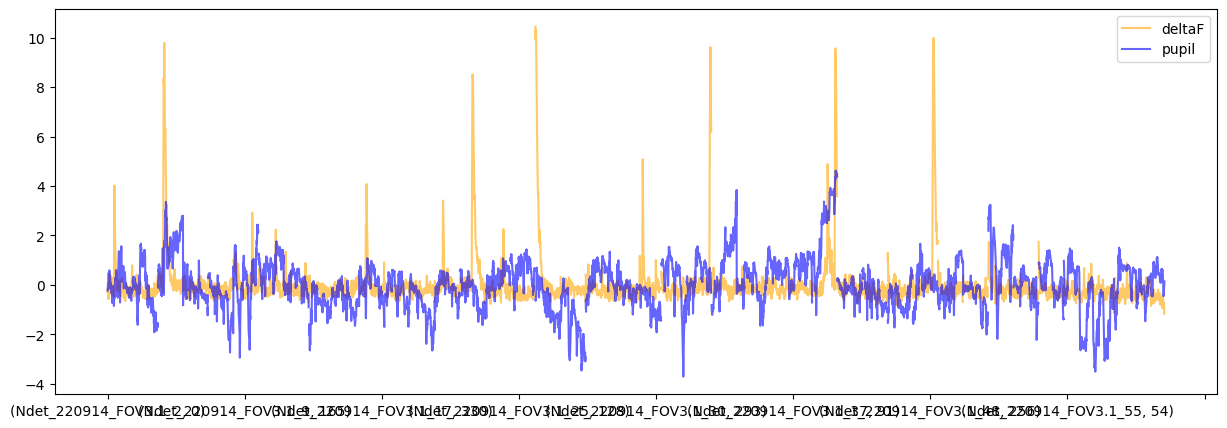

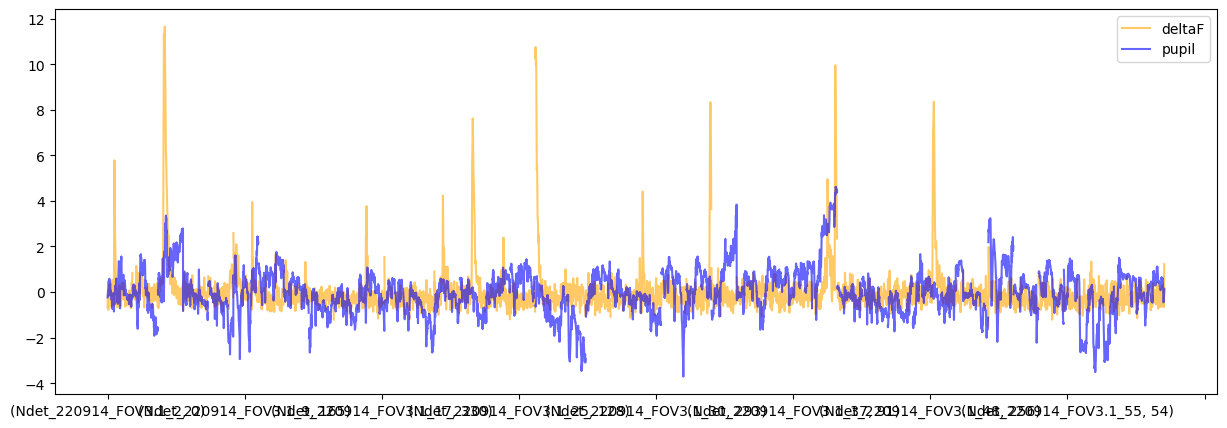

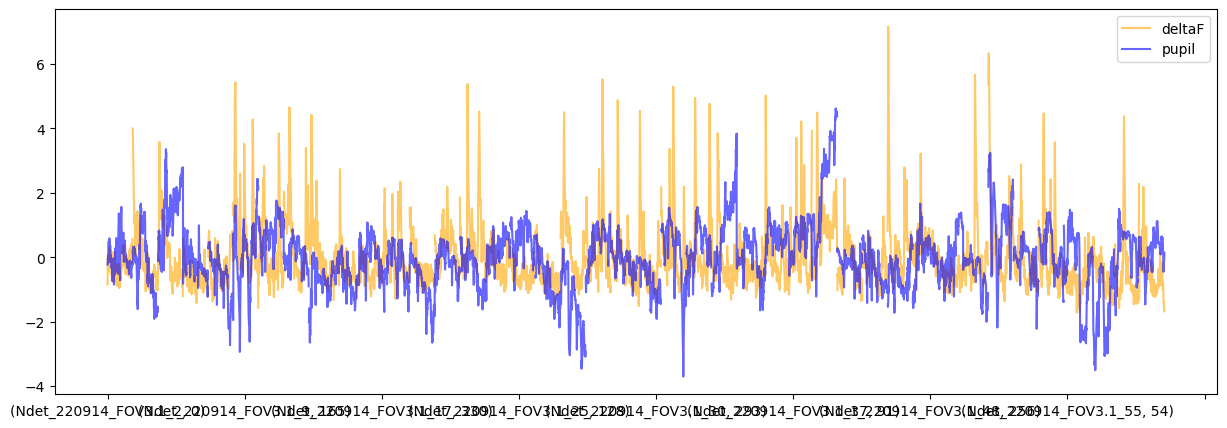

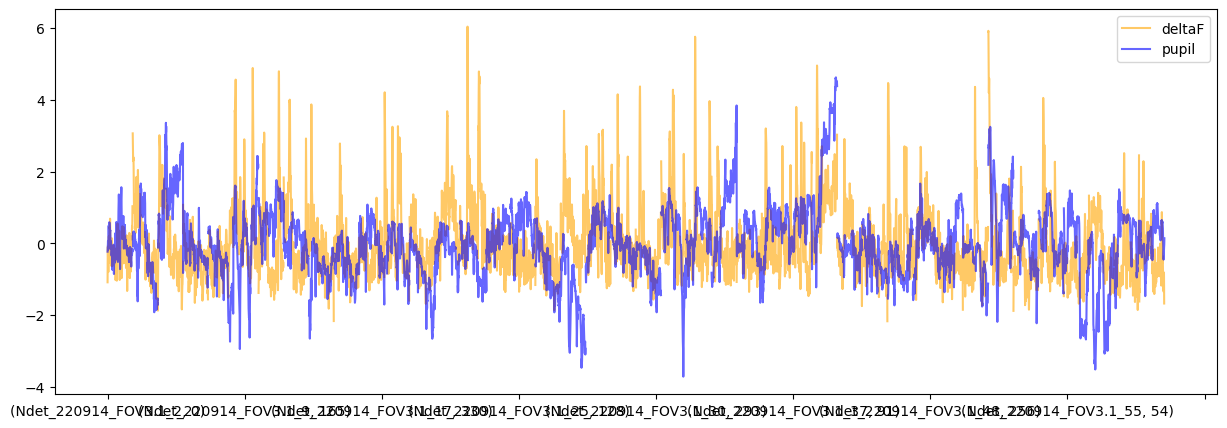

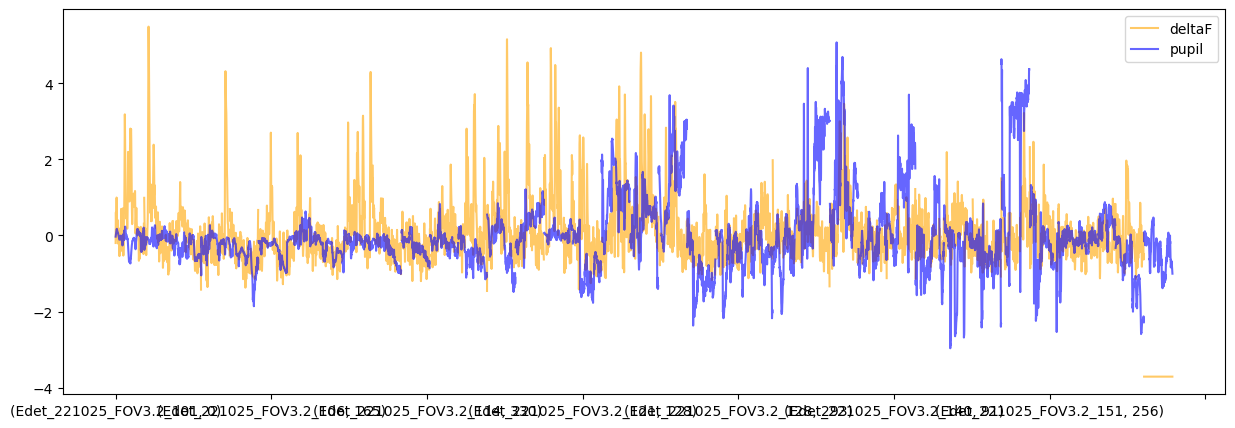

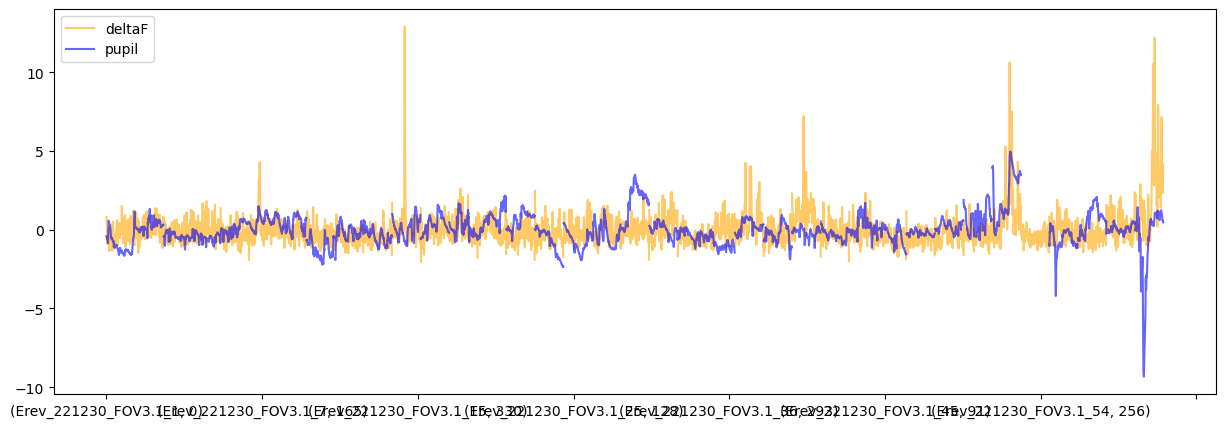

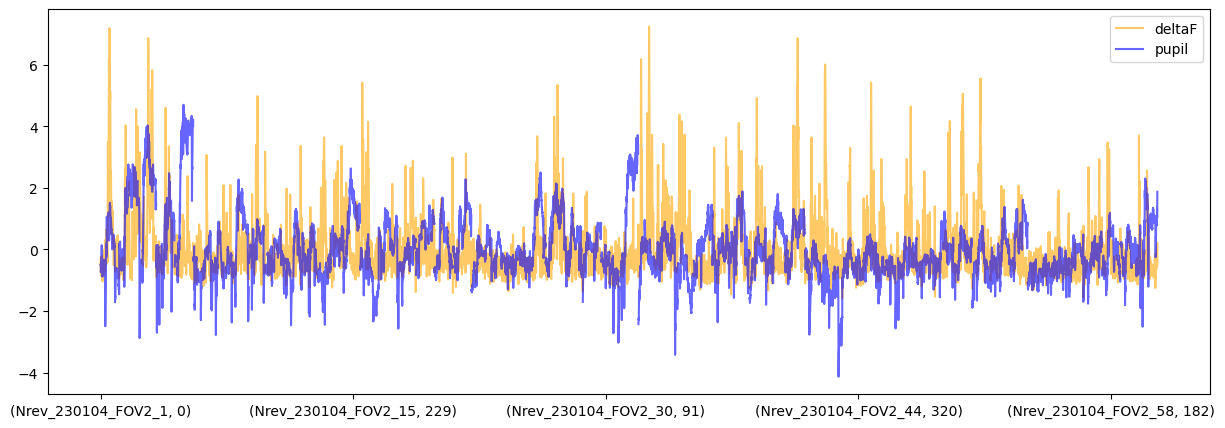

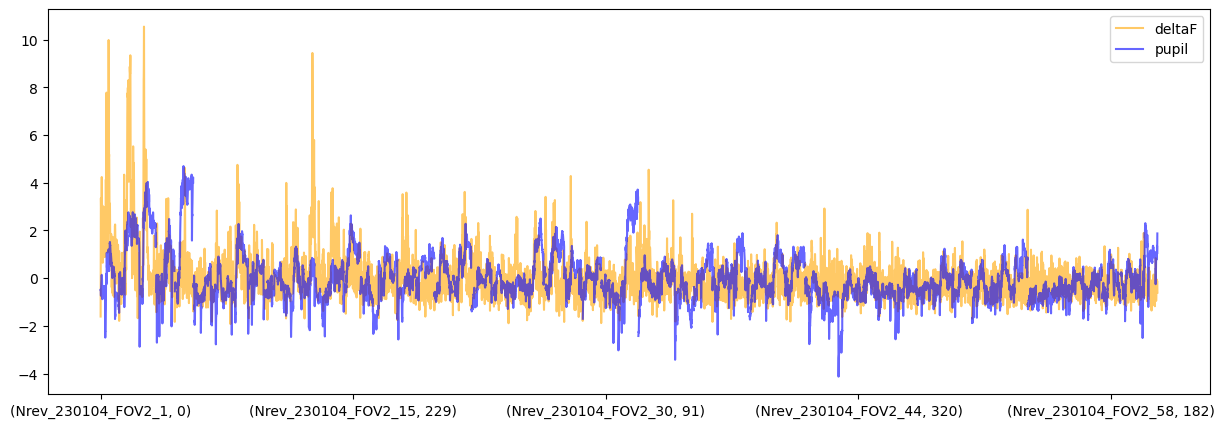

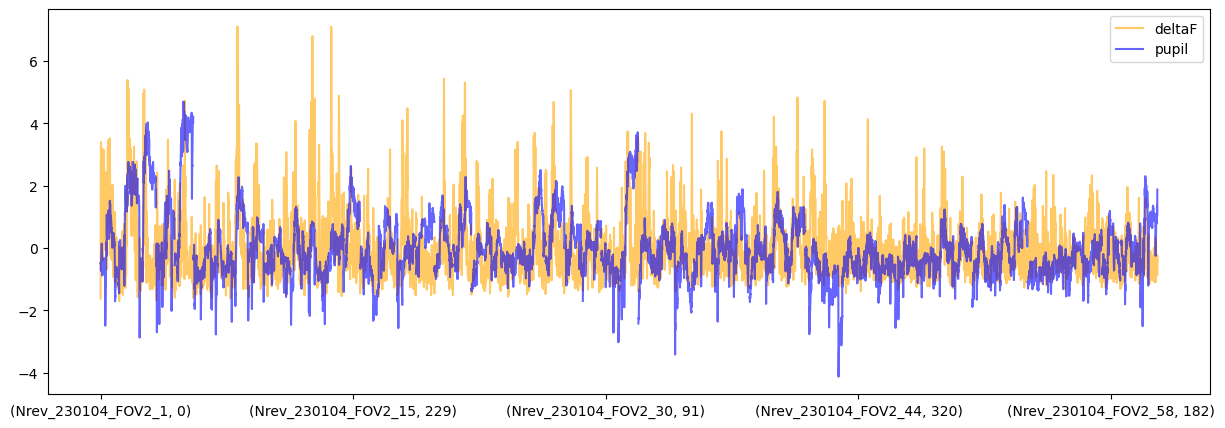

In [386]:
for mouse, mouse_dict in deltaF_pupil.items():
    if mouse not in somas:
        for ROI, ROI_dict in mouse_dict.items():
            deltaF = pd.DataFrame(ROI_dict['deltaF'])
            deltaF = (deltaF - deltaF.mean())/deltaF.std(ddof=0)
            pupil = pd.DataFrame(ROI_dict['pupil'])
            pupil = (pupil - pupil.mean())/pupil.std(ddof=0)
            
            df = pd.concat([deltaF, pupil], axis=1)
            rho = df.corr()
            r = rho['deltaF']['pupil']
            pval = (df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape))['deltaF']['pupil']
            
            if (pval < 0.05) & (abs(r > 0.15)):
                fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
                deltaF.plot(ax=ax, color='orange',alpha=0.6)
                pupil.plot(ax=ax, color='blue',alpha=0.6)
#             break
#     break

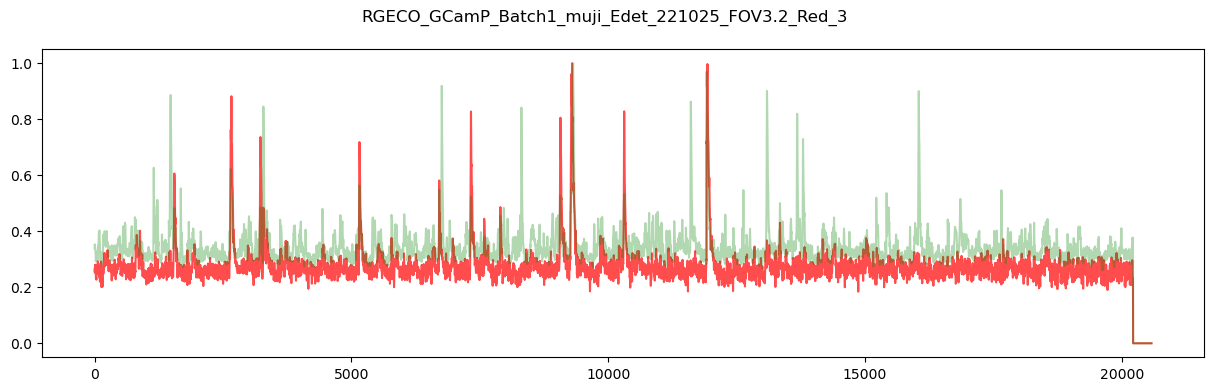

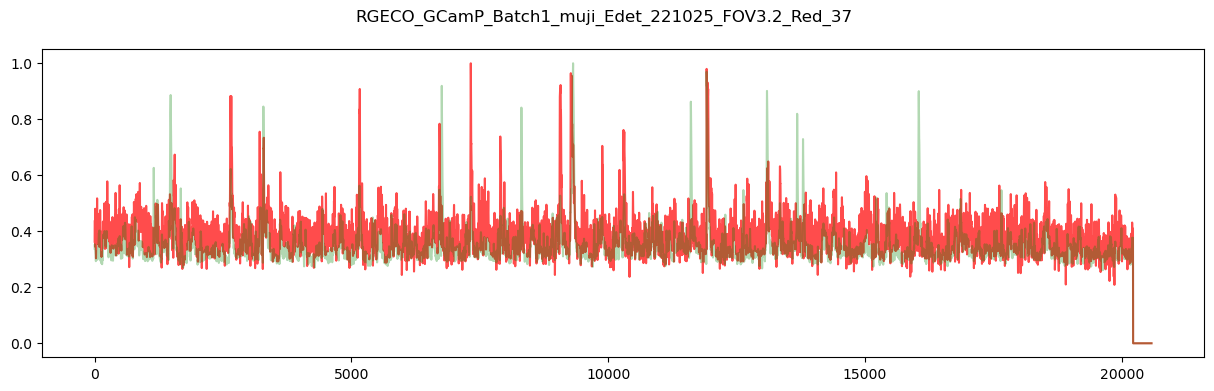

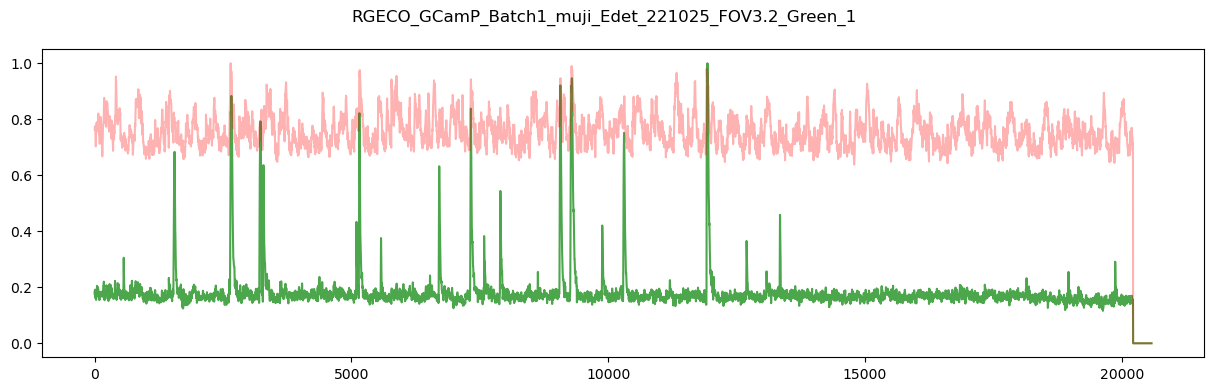

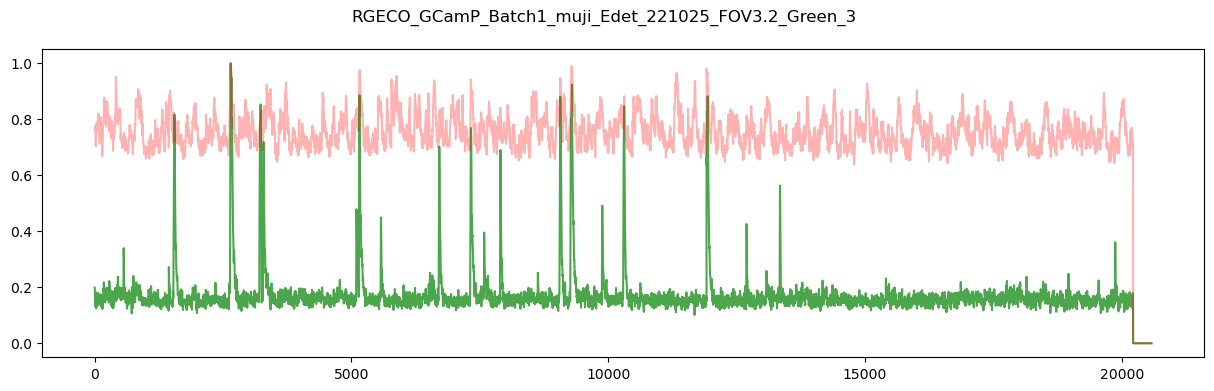

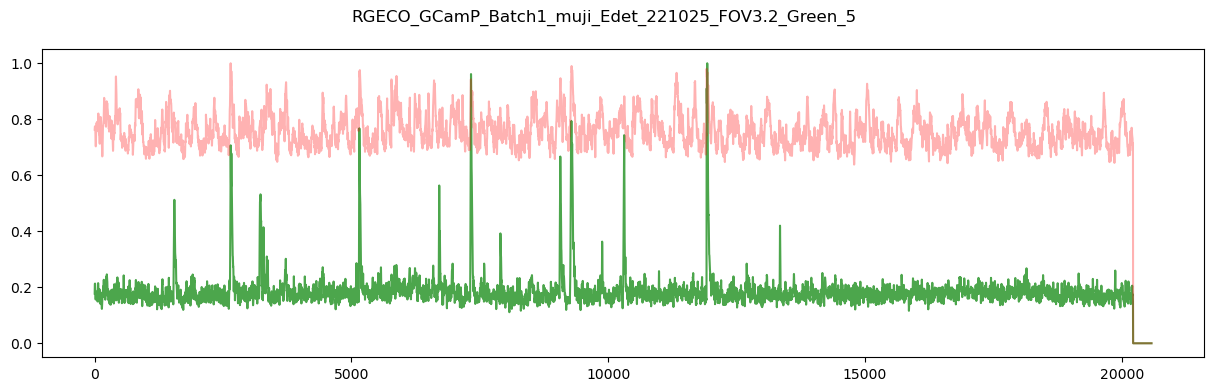

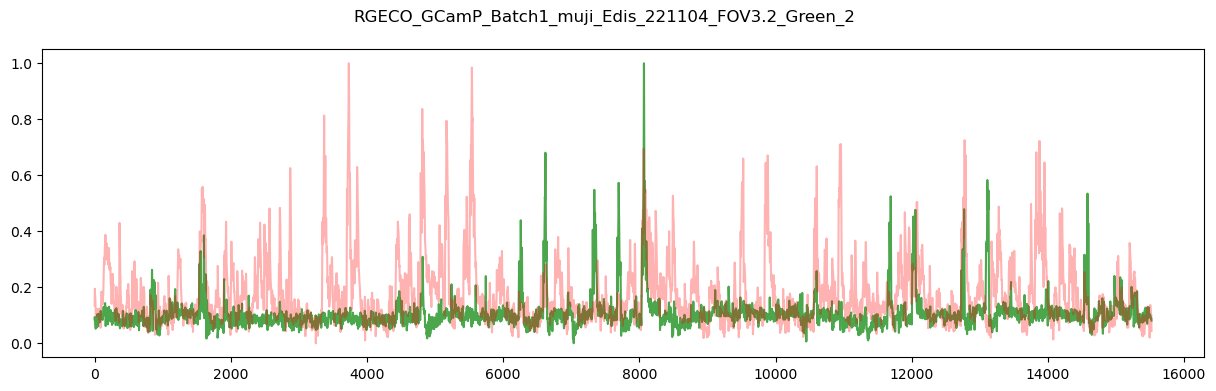

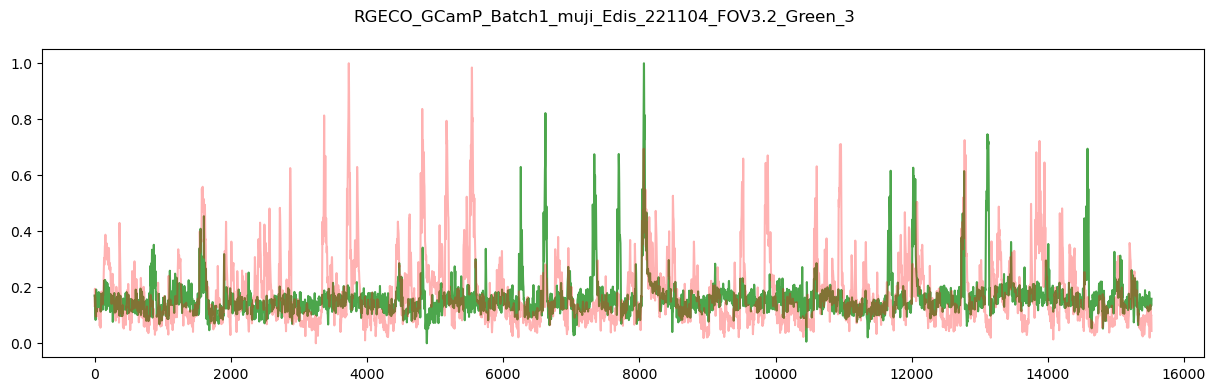

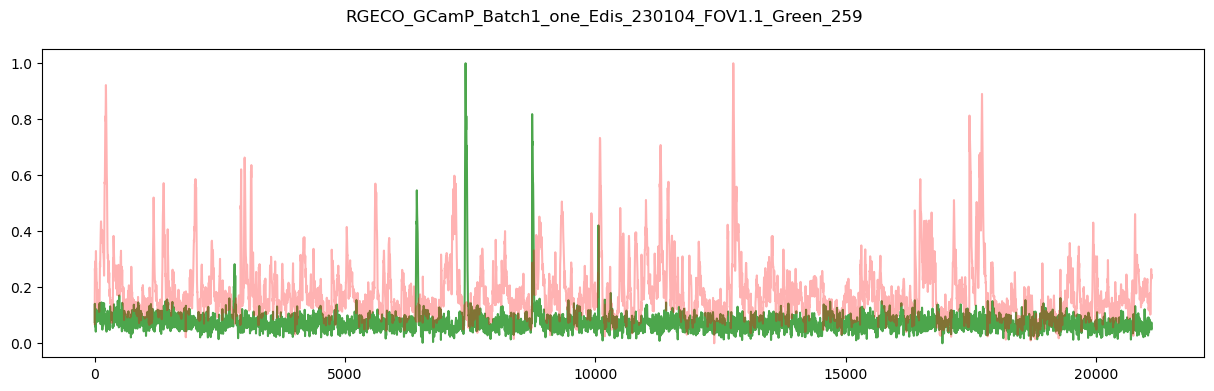

In [154]:
correlated_ROIs = []
for mouse, mouse_dict in cohort_correlations.items():
    inter = mouse_dict['inter-compartment']
    
    for index, rows in inter.iterrows():
        ID = mouse+'_'+index
        if (rows['avg_r'] > 0.8):
            mouse_deltaF = cohort_deltaF[mouse]
            sesh = ('_').join(index.split('_')[:-2])
            FOV_deltaF = mouse_deltaF[mouse_deltaF.index.get_level_values('Unique session') == sesh]
            ROI_deltaF = FOV_deltaF[FOV_deltaF.index.get_level_values('Unique_ROI') == index].iloc[:,2:-1]
            if 'Green' in index:
                other_pop = FOV_deltaF[FOV_deltaF.index.get_level_values('Channel') == 'Red'].iloc[:,2:-1]
                ROI_c = 'green'
                other_c = 'red'
            else:
                other_pop = FOV_deltaF[FOV_deltaF.index.get_level_values('Channel') == 'Green'].iloc[:,2:-1]
                ROI_c = 'red'
                other_c = 'green'
            ROI_flat = ROI_deltaF.to_numpy().flatten()
            ROI_flat = (ROI_flat - ROI_flat.min())/(ROI_flat.max()-ROI_flat.min())
            other_flat = other_pop.groupby(other_pop.index.get_level_values('Unique_trial')).mean().to_numpy().flatten()
            other_flat = (other_flat - other_flat.min())/(other_flat.max()-other_flat.min())
            plt.figure(figsize=(15,4))
            plt.plot(ROI_flat, color=ROI_c, alpha=0.7)
            plt.plot(other_flat, color=other_c, alpha=0.3)
            plt.suptitle(mouse+'_'+index)